In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle
import numpy as np
import pandas as pd
from music21 import converter, instrument, note, chord
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM, ConvLSTM2D
from keras.layers import Input
from keras.utils import np_utils
from keras.callbacks import History
from tensorflow.keras import optimizers
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [3]:
hist = History()

In [4]:
def categorical(arr, n_vocab):
    out = np.zeros((len(arr), n_vocab), dtype=int)
    for ind, value in enumerate(arr):
        out[ind, value] = 1
    return out

In [5]:
def most_frequent(List):
    while(1):
        com = max(set(List), key = List.count)
        if max(set(List), key = List.count) > 400:
            temp = []
            for i in List:
                if i < 400:
                    temp += [i]
            List = temp
        else:
            return com

In [6]:
def prepare_sequences(notes_train, notes_val, notes_test, n_vocab):
    pitchnames = set(item for item in notes_train).union(set((item for item in notes_val))).union(set(item for item in notes_test))
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    sequence_length = 100
    train_input = []
    train_output = []
    for i in range(0, len(notes_train) - sequence_length, sequence_length + 1):
        train_input_temp = []
        sequence_in = notes_train[i:i + sequence_length]
        sequence_out = notes_train[i + sequence_length]
        train_input_temp = [note_to_int[char] for char in sequence_in]
        common = most_frequent(train_input_temp)
        temp_1 = []
        for note in sequence_in:
            if note_to_int[note] >= 400:
                temp_1 += [common]
            else:
                temp_1 += [note_to_int[note]]
        train_input.append(temp_1)
        if note_to_int[sequence_out] >= 400:
            train_output.append(common)
        else:
            train_output.append(note_to_int[sequence_out])
    n_patterns = len(train_input)
    train_input = np.reshape(train_input, (n_patterns, sequence_length, 1))
    train_output = categorical(train_output, 400)

    val_input = []
    val_output = []
    for i in range(0, len(notes_val) - sequence_length, sequence_length + 1):
        sequence_in = notes_val[i:i + sequence_length]
        sequence_out = notes_val[i + sequence_length]
        val_input_temp = [note_to_int[char] for char in sequence_in]
        common = most_frequent(val_input_temp)
        temp_1 = []
        for note in sequence_in:
            if note_to_int[note] >= 400:
                temp_1 += [common]
            else:
                temp_1 += [note_to_int[note]]
        val_input.append(temp_1)
        if note_to_int[sequence_out] >= 400:
            val_output.append(common)
        else:
            val_output.append(note_to_int[sequence_out])
    n_patterns = len(val_input)
    val_input = np.reshape(val_input, (n_patterns, sequence_length, 1))
    val_output = categorical(val_output, 400)

    n_vocab_temp = len(set(notes_train).union(set(notes_val).union(set(notes_test))))
    with open('/content/drive/My Drive/maes/bindings', 'wb') as f:
        pickle.dump(note_to_int, f)

    return (train_input, train_output, val_input, val_output)

In [7]:
def create_network(network_input, n_vocab):
    model = Sequential()
    model.add(SimpleRNN(512, input_shape=(network_input.shape[1], network_input.shape[2]), return_sequences=True))
    model.add(SimpleRNN(512, return_sequences=True, recurrent_dropout=0.5))
    model.add(SimpleRNN(512, return_sequences=True, recurrent_dropout=0.5))
    model.add(SimpleRNN(512, recurrent_dropout=0.9))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(BatchNorm())
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    # was trying to change the learnig rates and other parameters, didn't work
    #rmsprop = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [8]:
def create_network_1(network_input, n_vocab):
    model = Sequential()
    model.add(LSTM(256,input_shape=(network_input.shape[1], network_input.shape[2]), return_sequences=True, recurrent_dropout=0.3))
    model.add(LSTM(128, return_sequences=True, recurrent_dropout=0.3))
    model.add(LSTM(128, return_sequences=True, recurrent_dropout=0.3))
    model.add(LSTM(128, recurrent_dropout=0.3))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(BatchNorm())
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    optimizer = optimizers.Adam(clipvalue=0.5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [9]:
with open('/content/drive/My Drive/maes/train_notes', 'rb') as f:
    notes_train = pickle.load(f)

with open('/content/drive/My Drive/maes/val_notes', 'rb') as f:
    notes_val = pickle.load(f)

with open('/content/drive/My Drive/maes/test_notes', 'rb') as f:
    notes_test = pickle.load(f)

train = []
for i in notes_train:
    if len(i) > 101:
        train += i[:101]
notes_train = train

val = []
for i in notes_val:
    if len(i) > 101:
        val += i[:101]
notes_val = val

test = []
for i in notes_test:
    if len(i) > 110:
        test += i[:110]
notes_test = test

# Prep

In [10]:
n_vocab_temp = len(set(notes_train).union(set(notes_val).union(set(notes_test))))
network_input_train, network_output_train, network_input_val, network_output_val = prepare_sequences(notes_train, notes_val, notes_test, n_vocab_temp)

In [11]:
n_vocab = 400

In [12]:
network_input_train.shape

(962, 100, 1)

In [13]:
network_input_val.shape

(137, 100, 1)

In [14]:
network_output_train.shape

(962, 400)

In [15]:
network_output_val.shape

(137, 400)

In [16]:
n_vocab

400

# LSTM 1

In [18]:
model = create_network_1(network_input_train, n_vocab)
filepath = "/content/drive/My Drive/maes/check/1/weights-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
print(model.summary())
hist = model.fit(network_input_train, network_output_train, epochs = 100,
            validation_data = (network_input_val, network_output_val), 
            batch_size = 128, callbacks=callbacks_list)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100, 256)          264192    
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 128)          197120    
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 128)          131584    
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

## Plotting the graphs

In [19]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

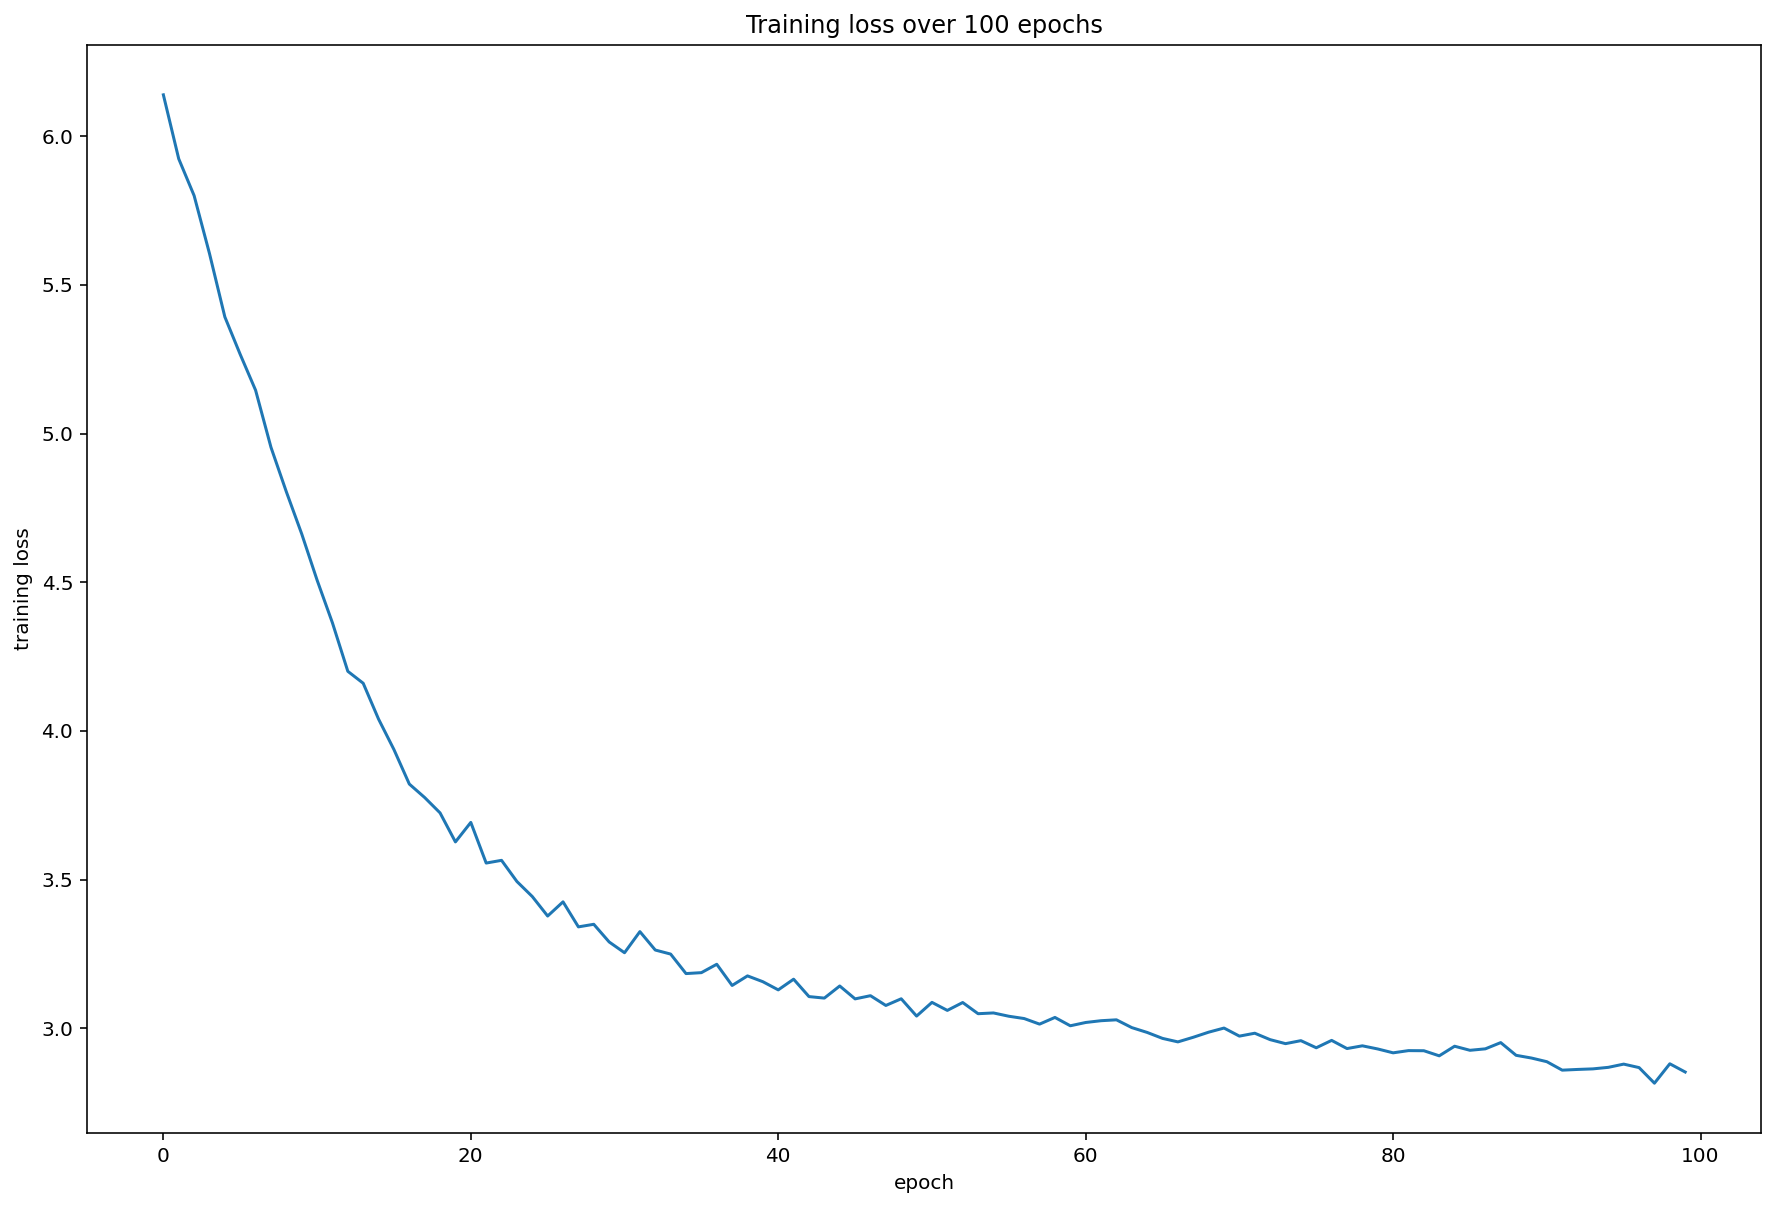

In [20]:
plt.figure(figsize=(15, 10))
plt.plot(list(hist.history.values())[0])
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.title('Training loss over 100 epochs')
plt.show()

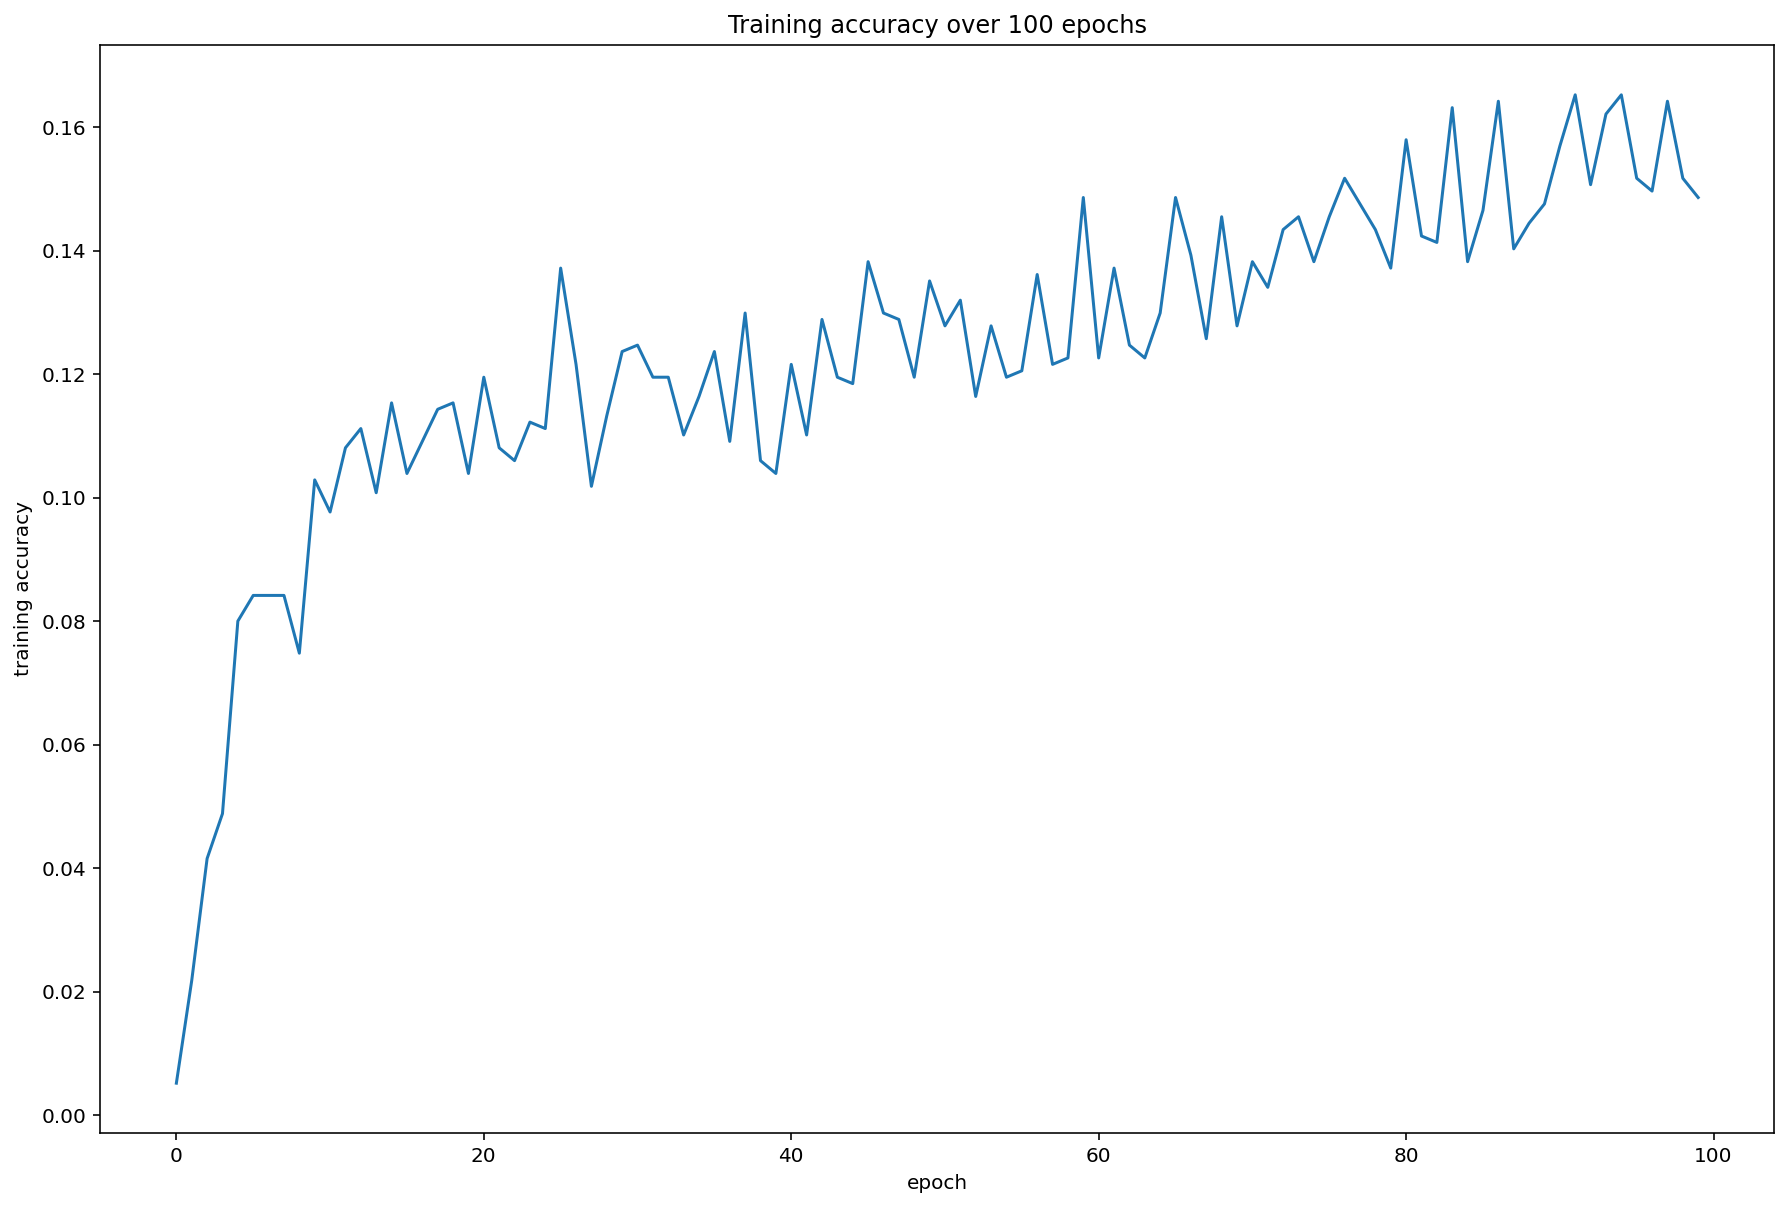

In [21]:
plt.figure(figsize=(15, 10))
plt.plot(list(hist.history.values())[1])
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.title('Training accuracy over 100 epochs')
plt.show()

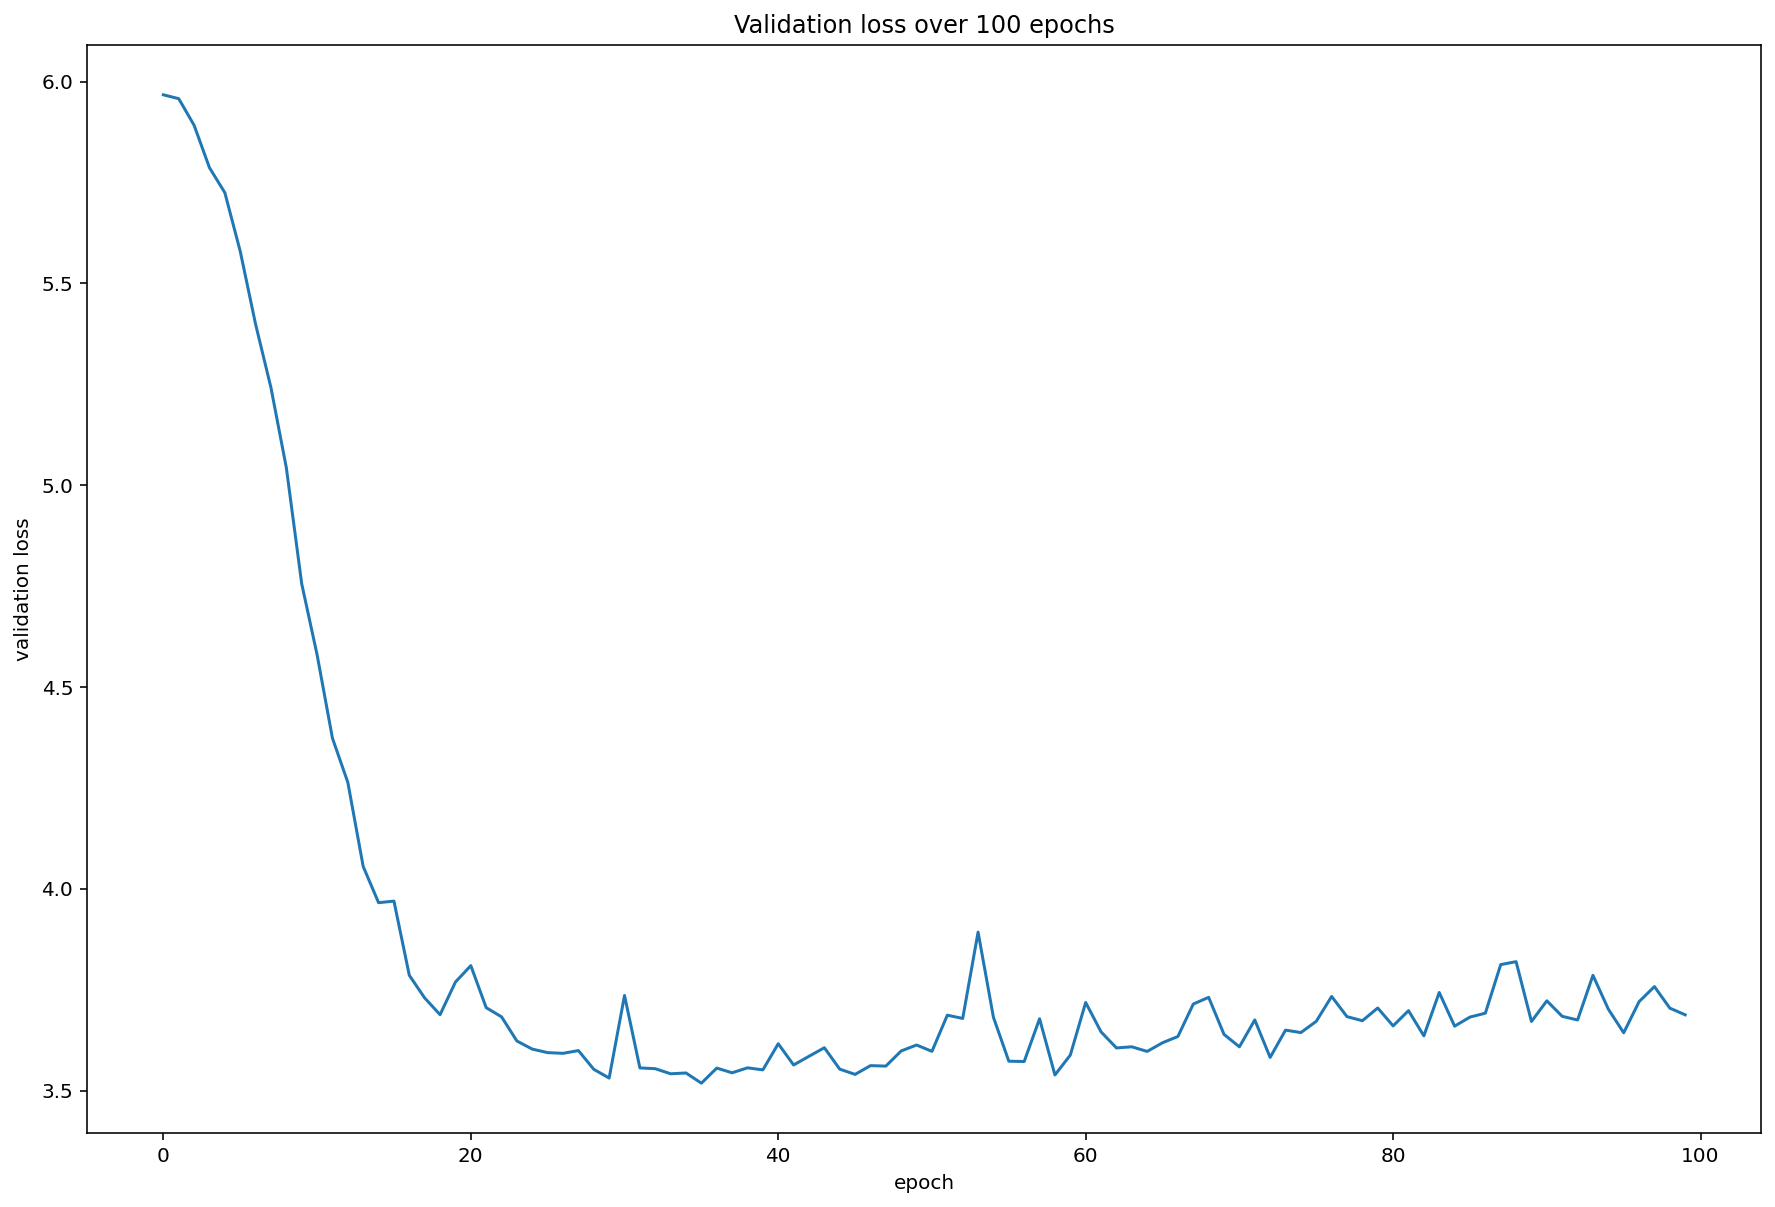

In [22]:
plt.figure(figsize=(15, 10))
plt.plot(list(hist.history.values())[2])
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.title('Validation loss over 100 epochs')
plt.show()

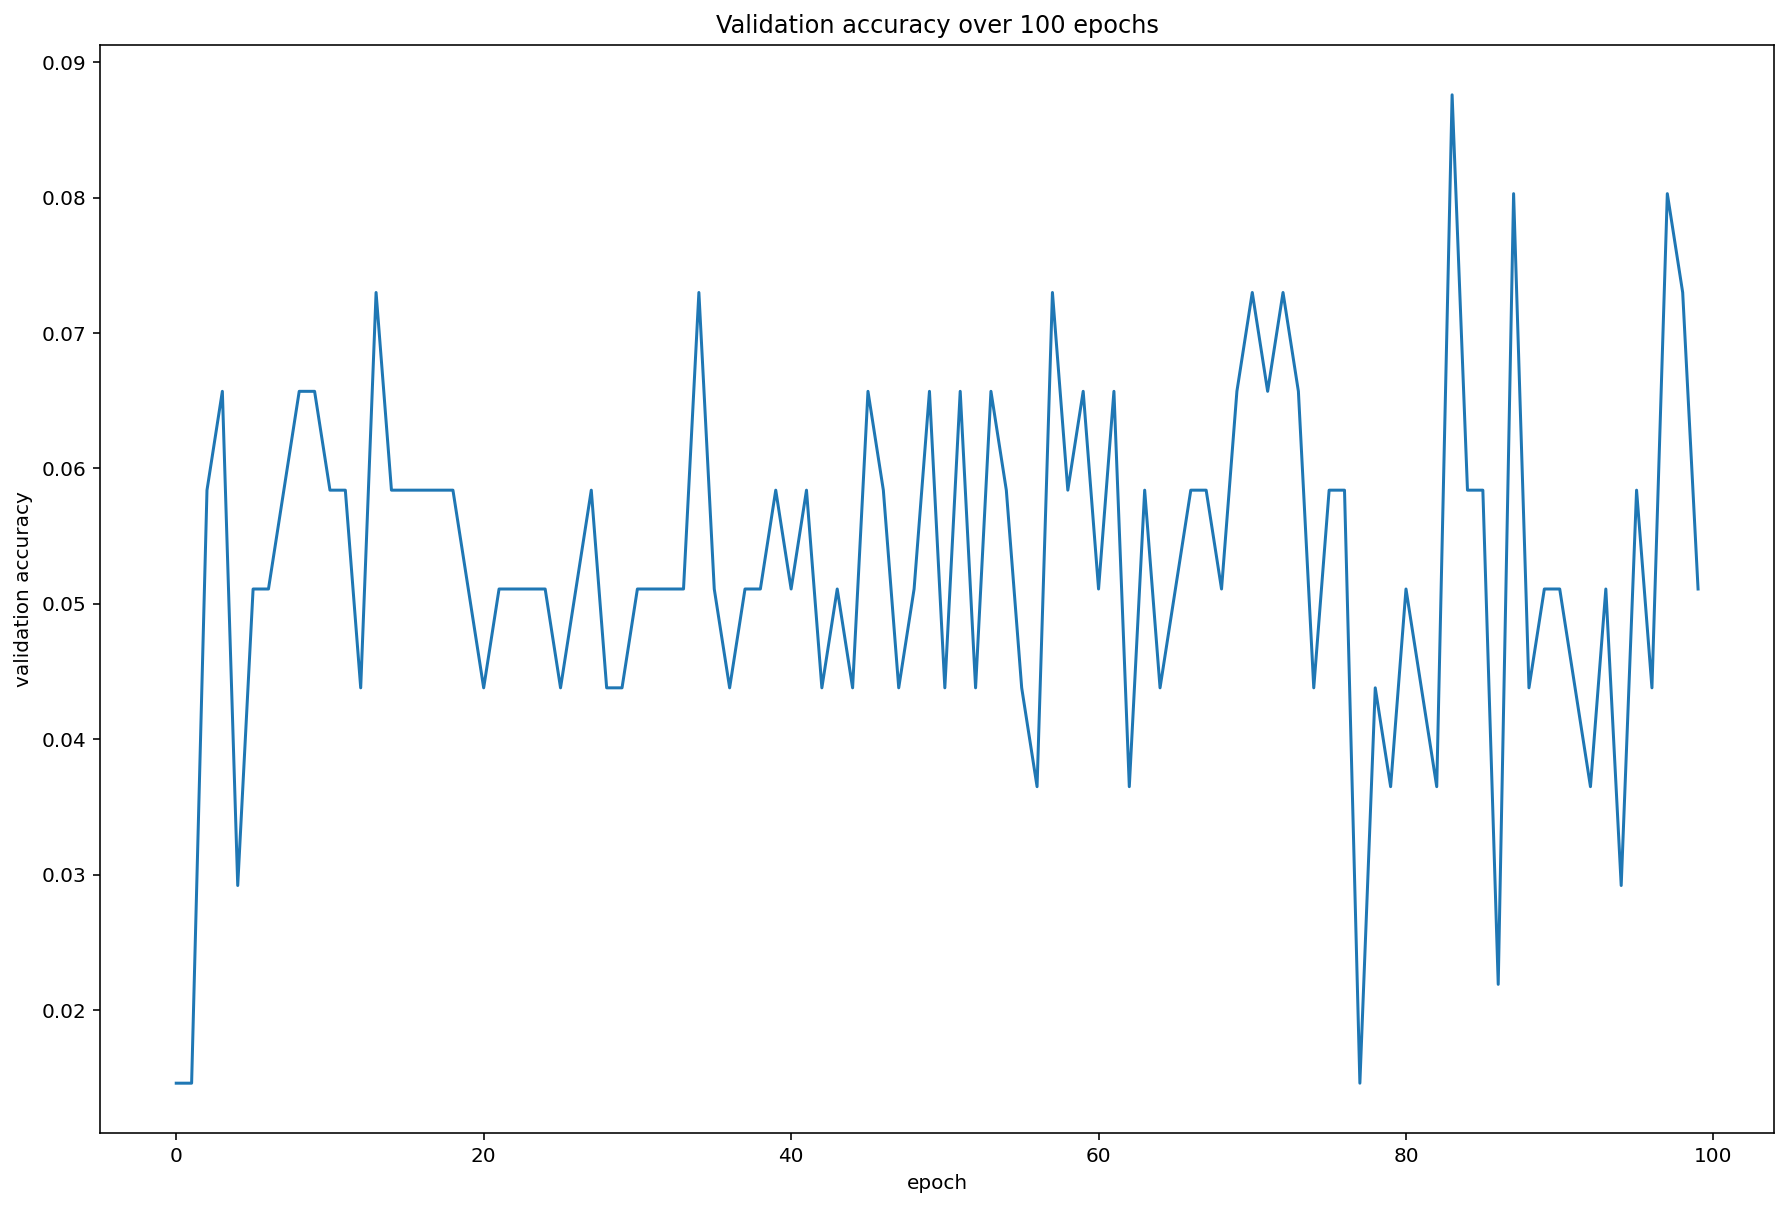

In [23]:
plt.figure(figsize=(15, 10))
plt.plot(list(hist.history.values())[3])
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('Validation accuracy over 100 epochs')
plt.show()

#RNN 1

In [24]:
model = create_network(network_input_train, n_vocab)
filepath = "/content/drive/My Drive/maes/check/2/weights-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
print(model.summary())
hist_1 = model.fit(network_input_train, network_output_train, epochs = 100,
            validation_data = (network_input_val, network_output_val), 
            batch_size = 128, callbacks=callbacks_list)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 100, 512)          263168    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100, 512)          524800    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100, 512)          524800    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 512)               524800    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)              

## Plotting Graphs

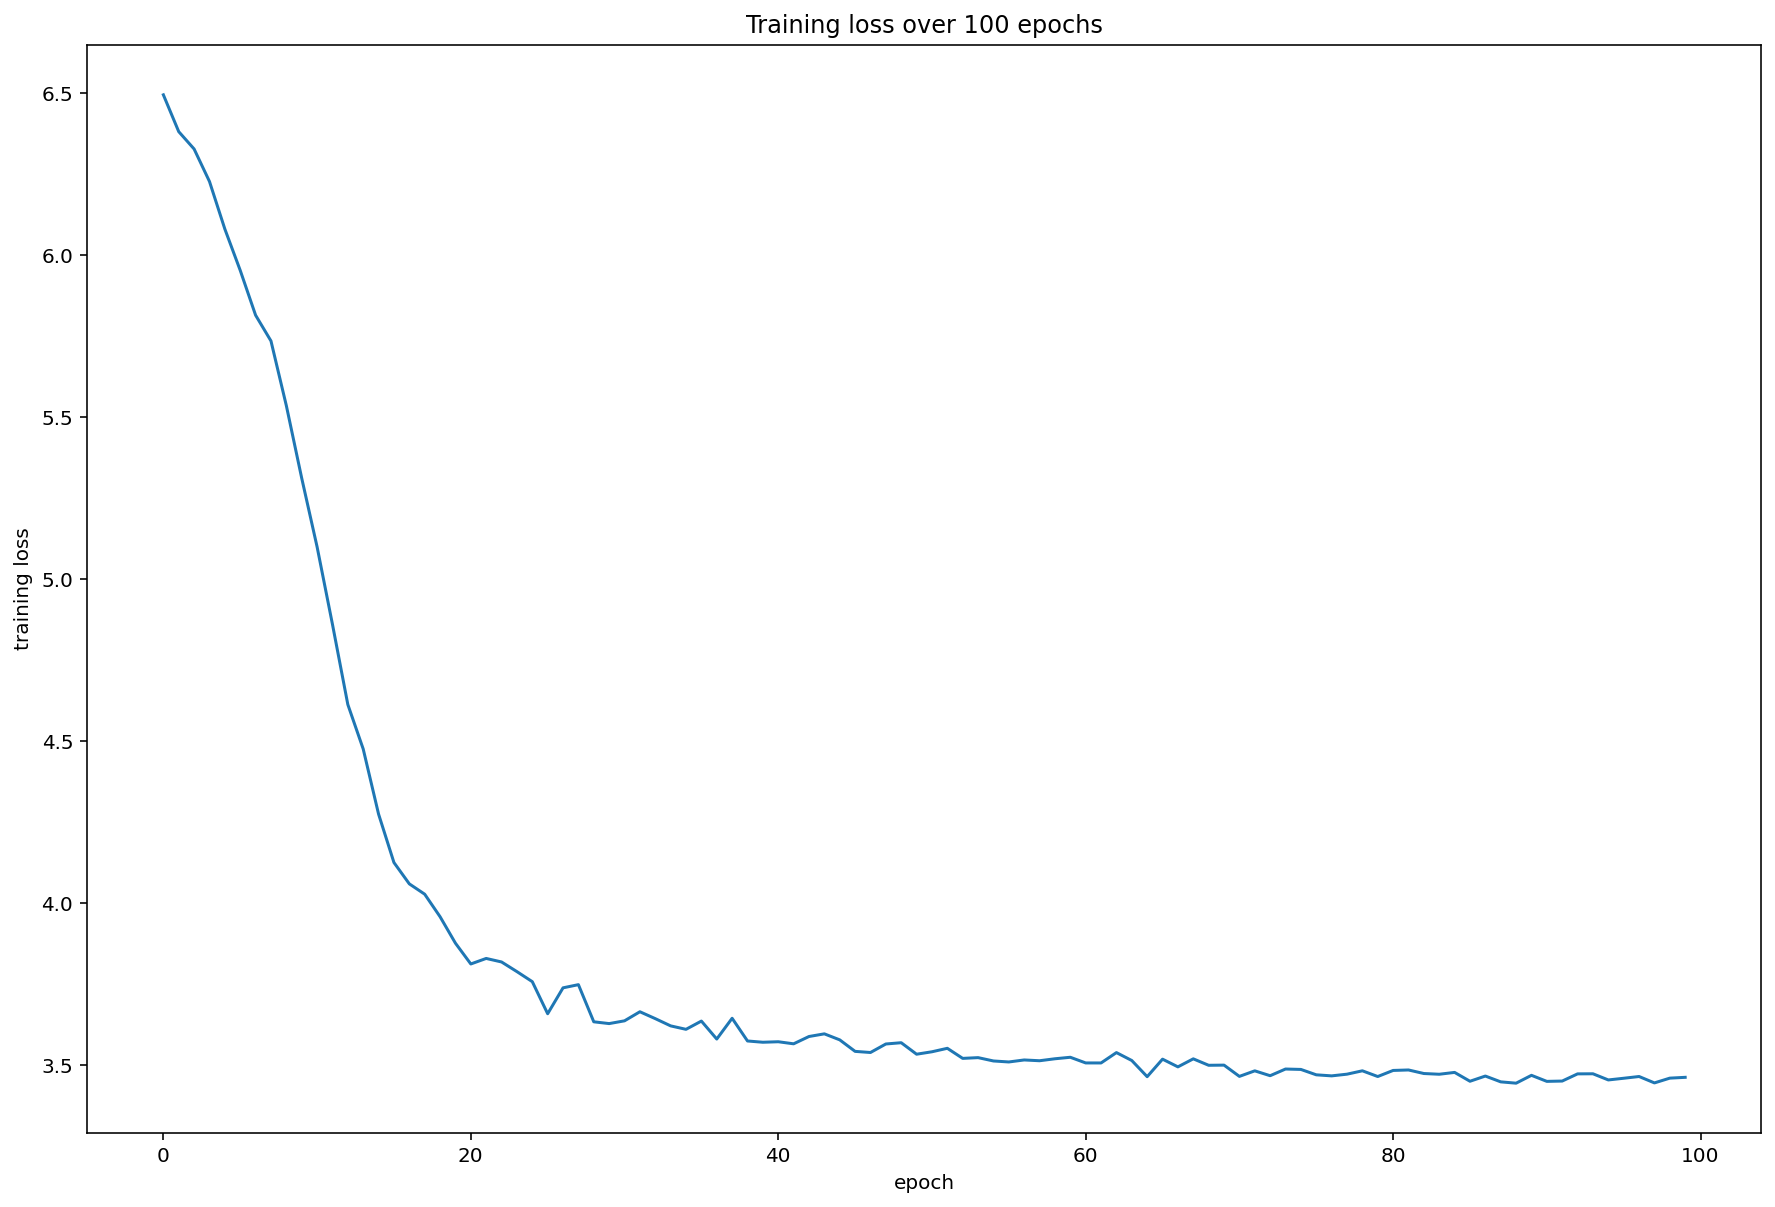

In [25]:
plt.figure(figsize=(15, 10))
plt.plot(list(hist_1.history.values())[0])
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.title('Training loss over 100 epochs')
plt.show()

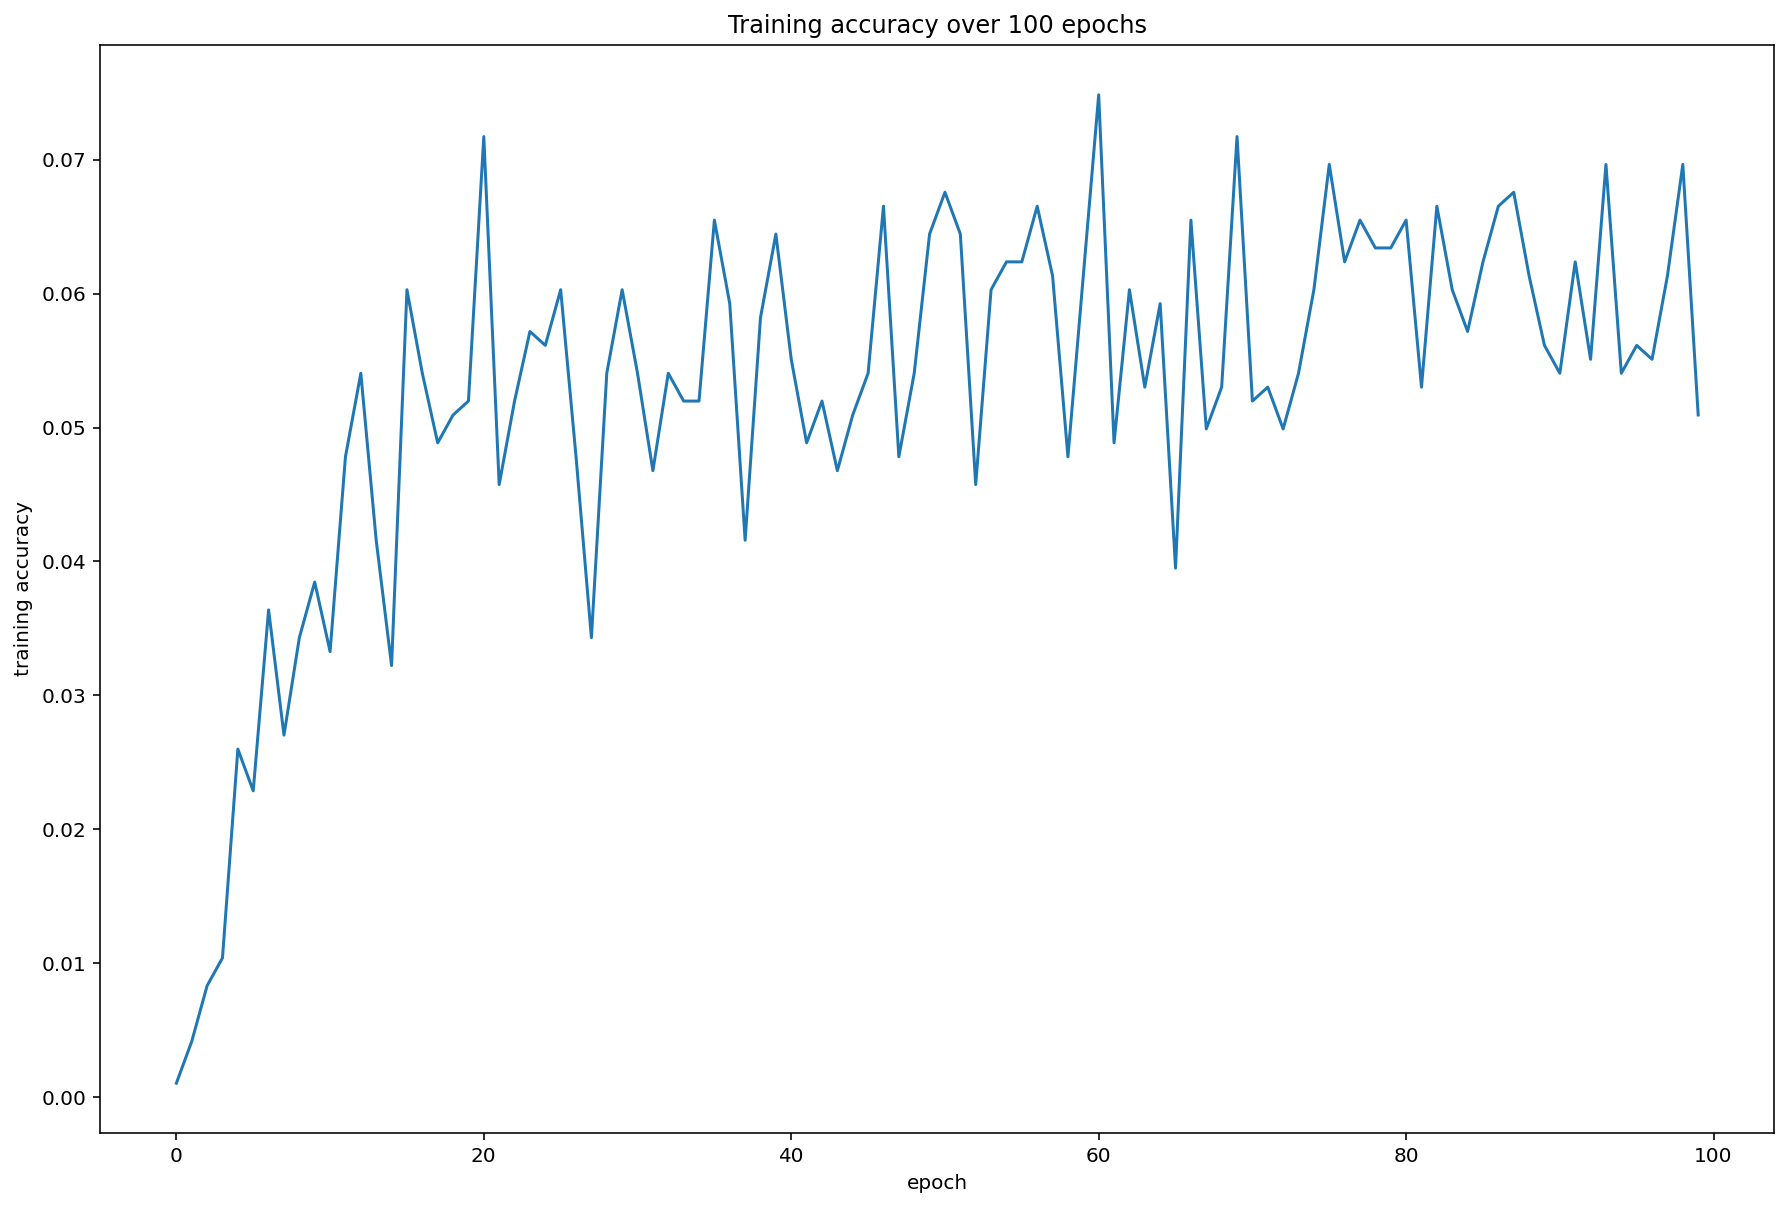

In [26]:
plt.figure(figsize=(15, 10))
plt.plot(list(hist_1.history.values())[1])
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.title('Training accuracy over 100 epochs')
plt.show()

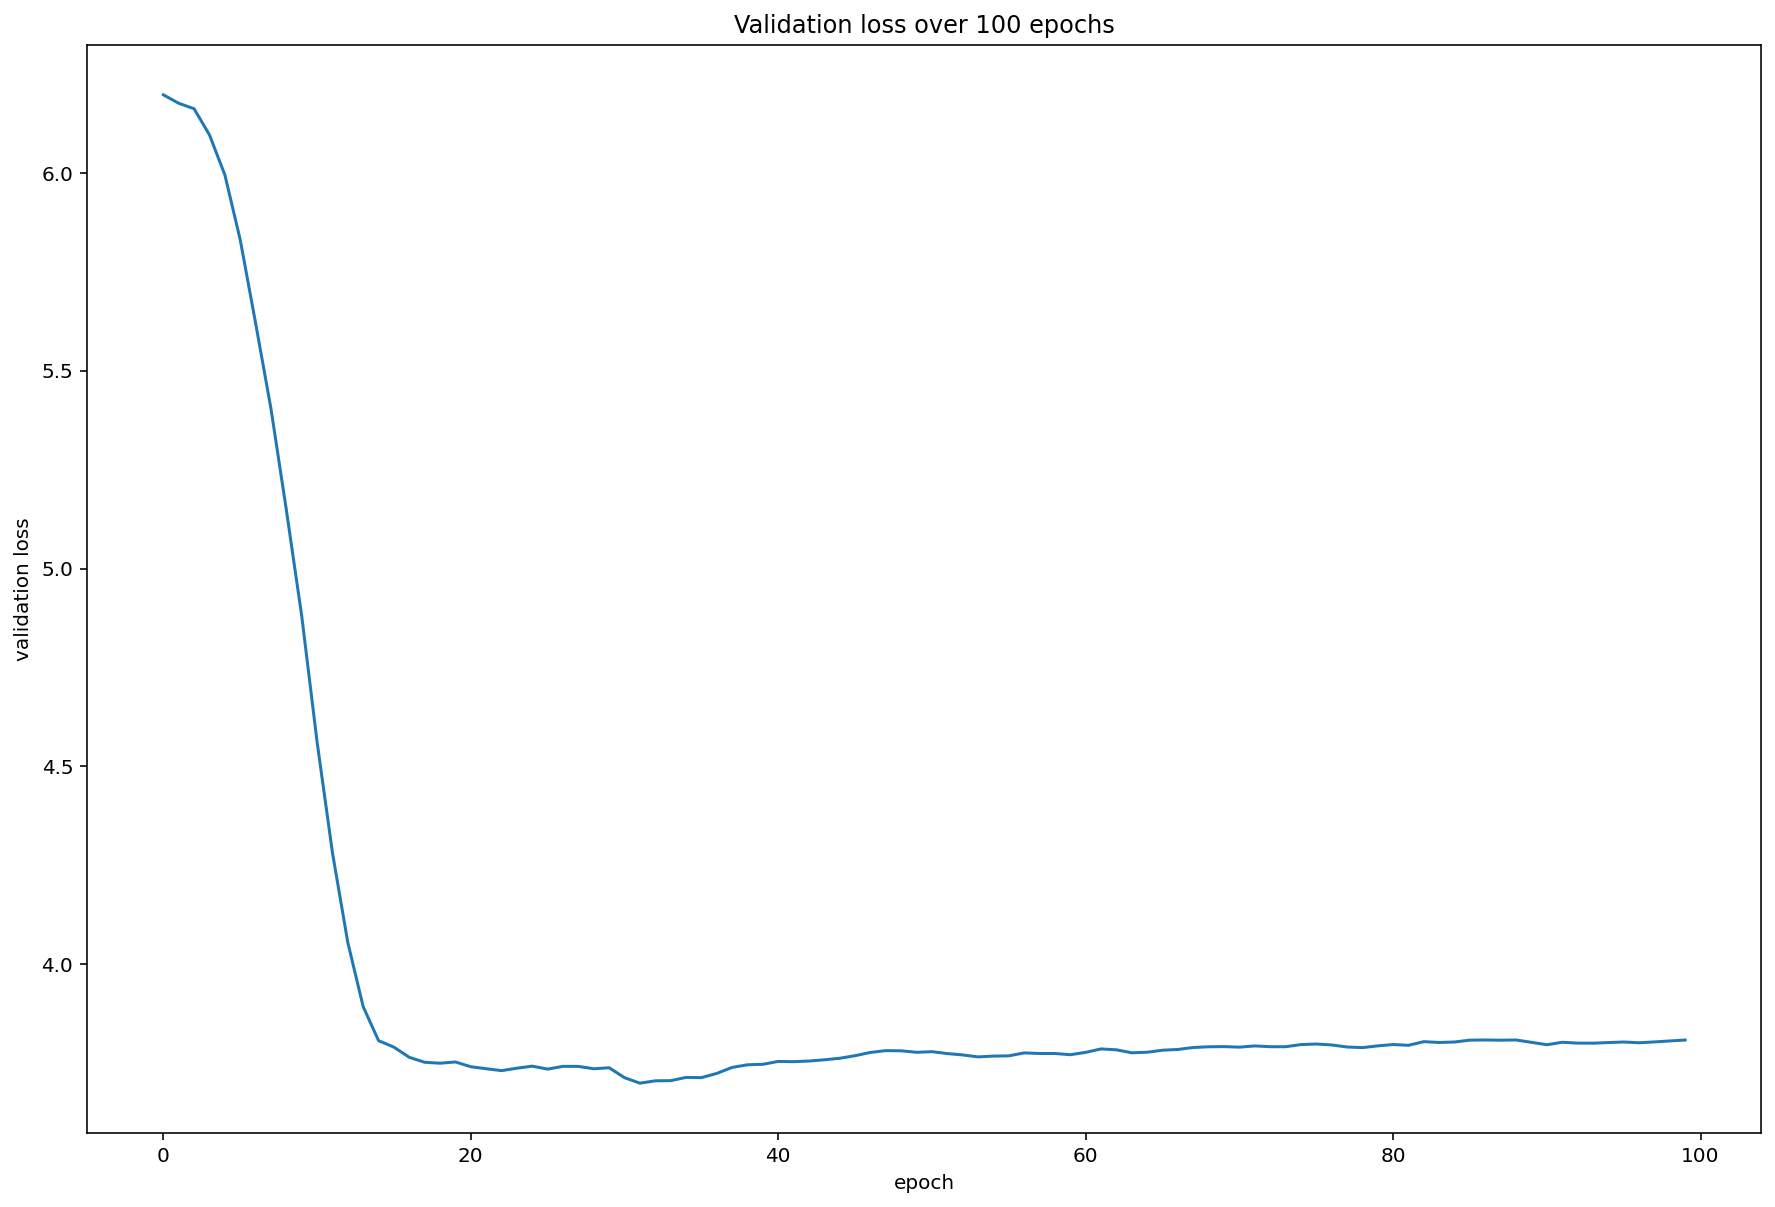

In [27]:
plt.figure(figsize=(15, 10))
plt.plot(list(hist_1.history.values())[2])
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.title('Validation loss over 100 epochs')
plt.show()

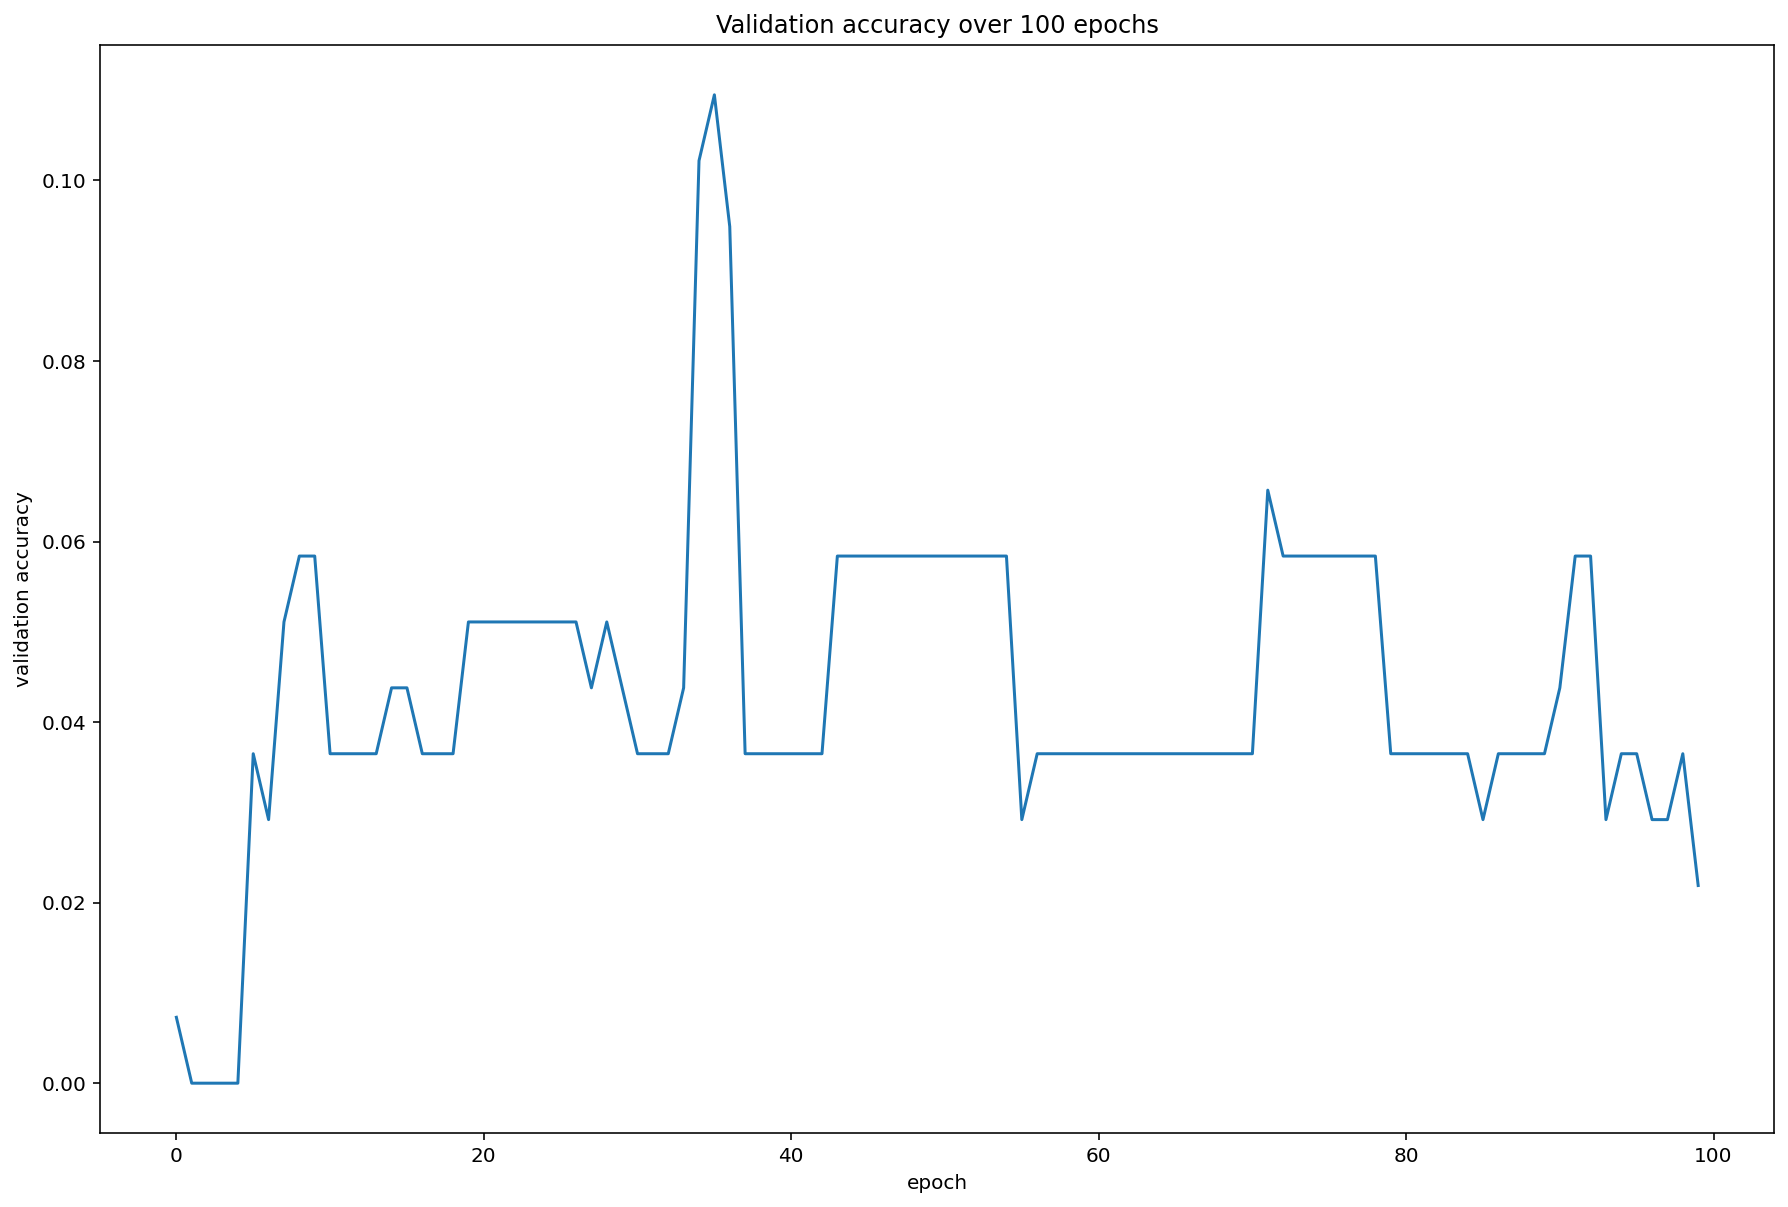

In [28]:
plt.figure(figsize=(15, 10))
plt.plot(list(hist_1.history.values())[3])
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('Validation accuracy over 100 epochs')
plt.show()

# Prep

In [29]:
def prepare_sequences_1(notes_train, notes_val, notes_test, n_vocab):
    pitchnames = set(item for item in notes_train).union(set((item for item in notes_val))).union(set(item for item in notes_test))
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    sequence_length = 100
    train_input = []
    train_output = []
    for i in range(0, len(notes_train) - sequence_length,10):
        train_input_temp = []
        sequence_in = notes_train[i:i + sequence_length]
        sequence_out = notes_train[i + sequence_length]
        train_input_temp = [note_to_int[char] for char in sequence_in]
        common = most_frequent(train_input_temp)
        temp_1 = []
        for note in sequence_in:
            if note_to_int[note] >= 400:
                temp_1 += [common]
            else:
                temp_1 += [note_to_int[note]]
        train_input.append(temp_1)
        if note_to_int[sequence_out] >= 400:
            train_output.append(common)
        else:
            train_output.append(note_to_int[sequence_out])
    n_patterns = len(train_input)
    train_input = np.reshape(train_input, (n_patterns, sequence_length, 1))
    train_output = categorical(train_output, 400)

    val_input = []
    val_output = []
    for i in range(0, len(notes_val) - sequence_length, sequence_length + 1):
        sequence_in = notes_val[i:i + sequence_length]
        sequence_out = notes_val[i + sequence_length]
        val_input_temp = [note_to_int[char] for char in sequence_in]
        common = most_frequent(val_input_temp)
        temp_1 = []
        for note in sequence_in:
            if note_to_int[note] >= 400:
                temp_1 += [common]
            else:
                temp_1 += [note_to_int[note]]
        val_input.append(temp_1)
        if note_to_int[sequence_out] >= 400:
            val_output.append(common)
        else:
            val_output.append(note_to_int[sequence_out])
    n_patterns = len(val_input)
    val_input = np.reshape(val_input, (n_patterns, sequence_length, 1))
    val_output = categorical(val_output, 400)

    n_vocab_temp = len(set(notes_train).union(set(notes_val).union(set(notes_test))))
    with open('/content/drive/My Drive/maes/bindings', 'wb') as f:
        pickle.dump(note_to_int, f)

    return (train_input, train_output, val_input, val_output)

In [30]:
n_vocab_temp = len(set(notes_train).union(set(notes_val).union(set(notes_test))))
network_input_train, network_output_train, network_input_val, network_output_val = prepare_sequences_1(notes_train, notes_val, notes_test, n_vocab_temp)

In [31]:
n_vocab = 400

In [32]:
network_input_train.shape

(9707, 100, 1)

In [33]:
network_input_val.shape

(137, 100, 1)

In [34]:
network_output_train.shape

(9707, 400)

In [35]:
network_output_val.shape

(137, 400)

# LSTM 2

In [36]:
model = create_network_1(network_input_train, n_vocab)
filepath = "/content/drive/My Drive/maes/check/3/weights-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
print(model.summary())
hist_2 = model.fit(network_input_train, network_output_train, epochs = 20,
            validation_data = (network_input_val, network_output_val), 
            batch_size = 128, callbacks=callbacks_list)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 100, 256)          264192    
_________________________________________________________________
lstm_9 (LSTM)                (None, 100, 128)          197120    
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 128)          131584    
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               131584    
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)              

## Plotting Graphs

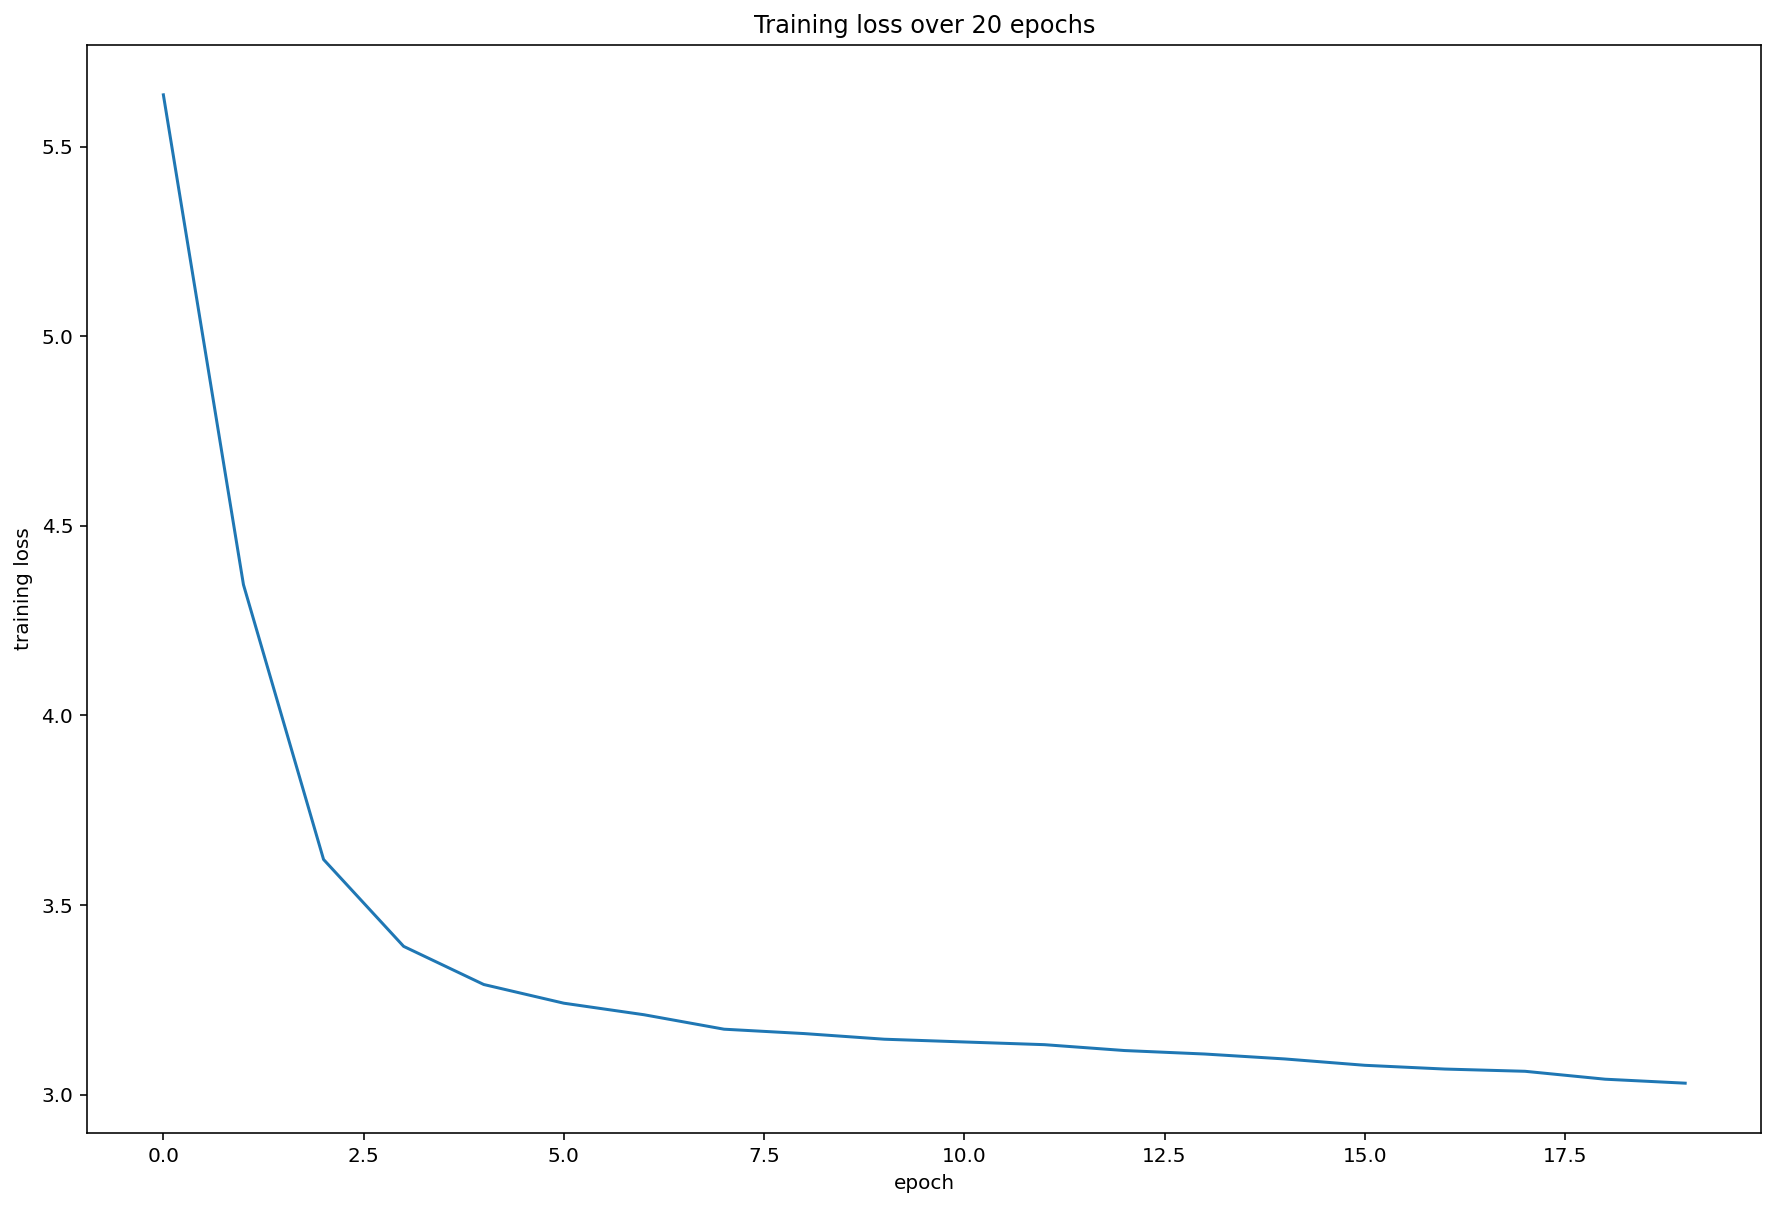

In [37]:
plt.figure(figsize=(15, 10))
plt.plot(list(hist_2.history.values())[0])
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.title('Training loss over 20 epochs')
plt.show()

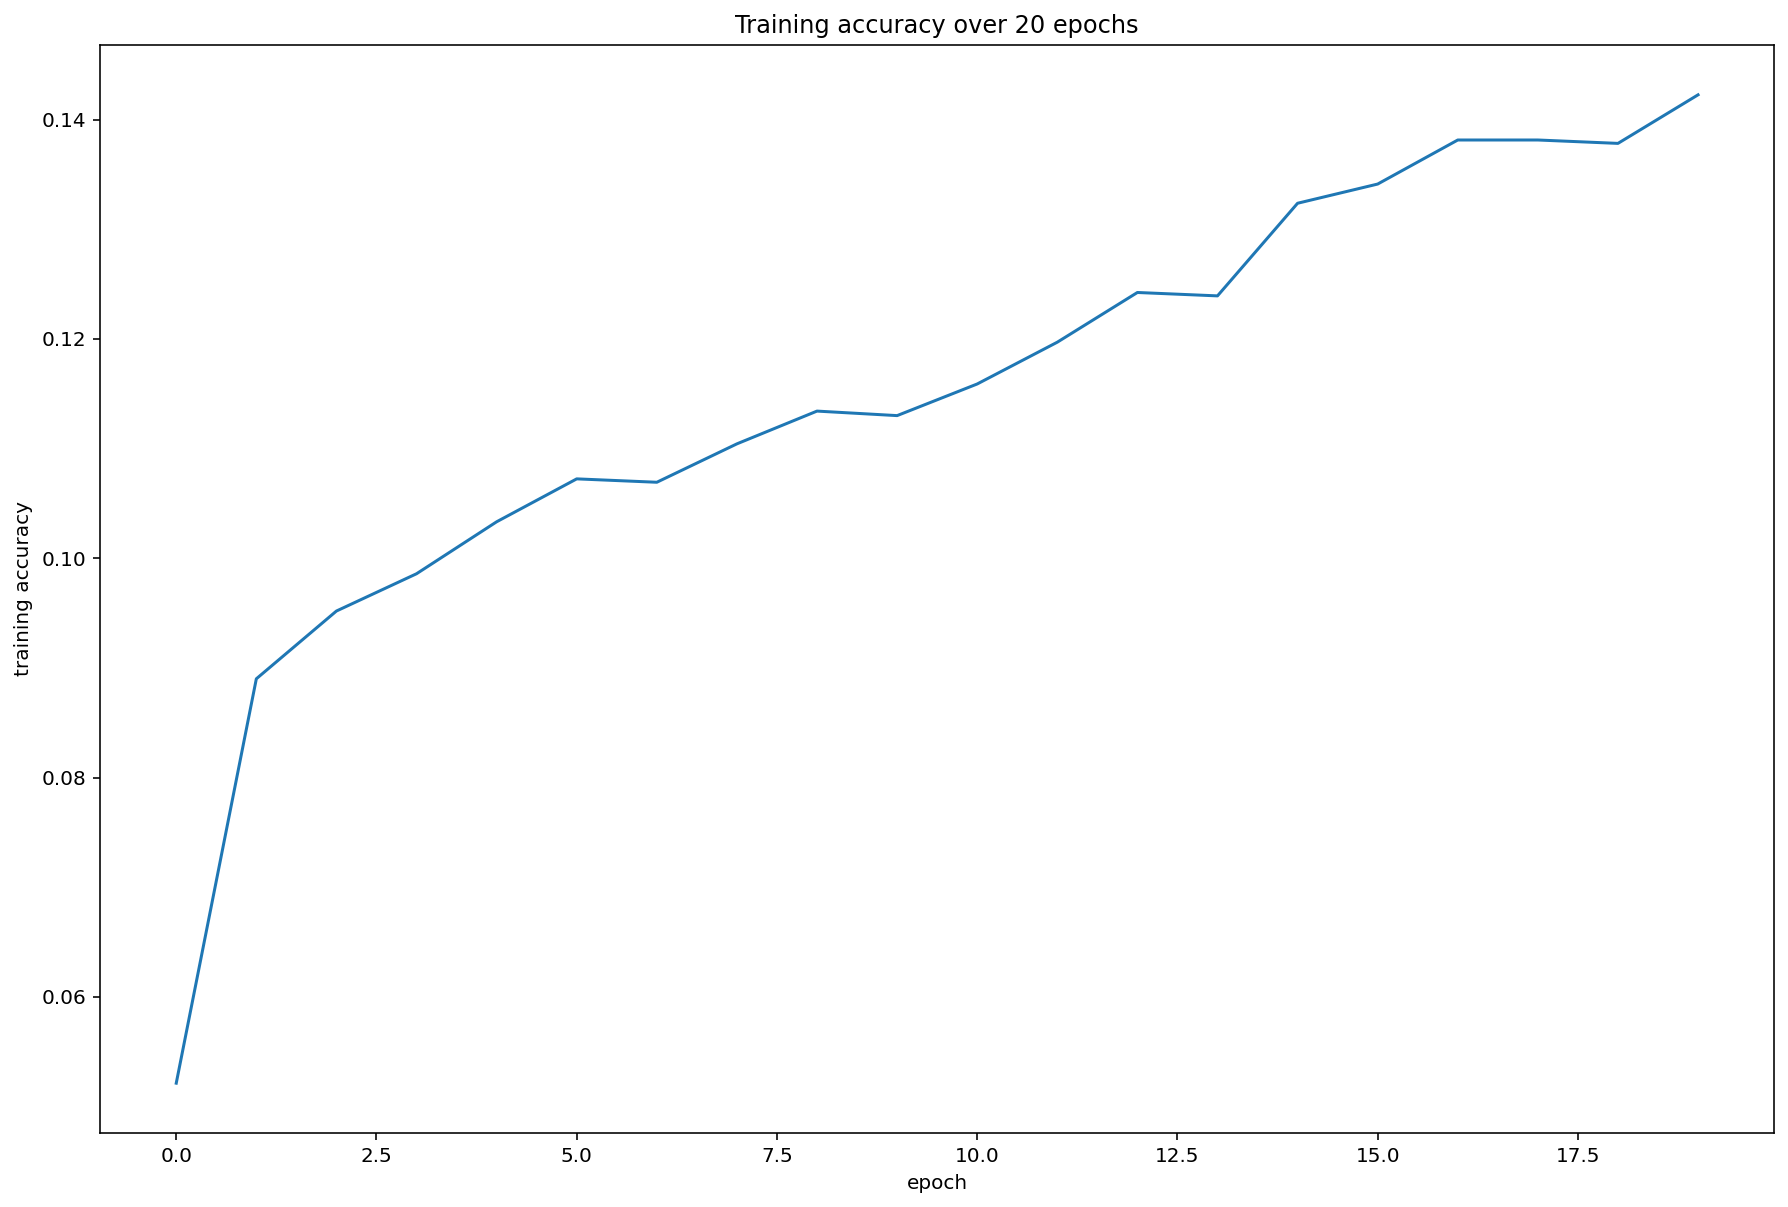

In [38]:
plt.figure(figsize=(15, 10))
plt.plot(list(hist_2.history.values())[1])
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.title('Training accuracy over 20 epochs')
plt.show()

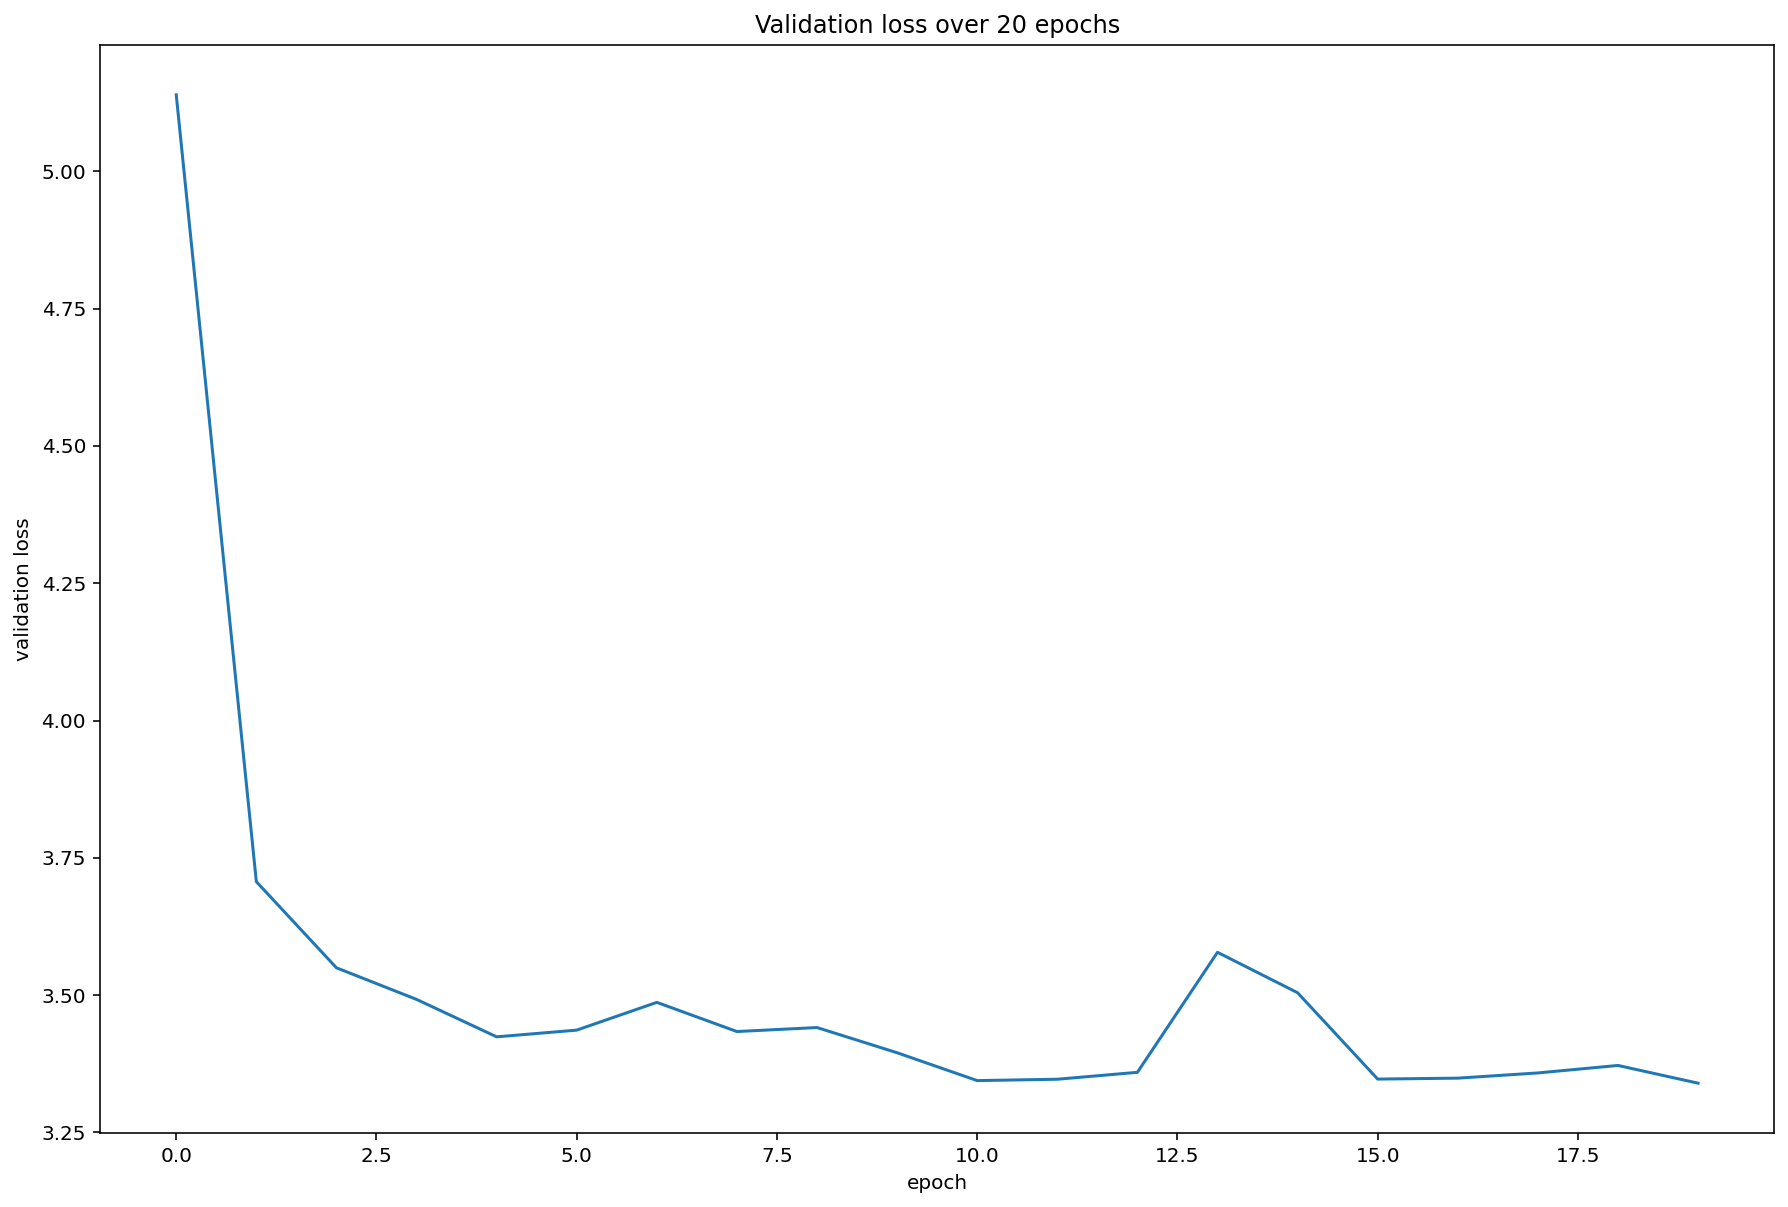

In [39]:
plt.figure(figsize=(15, 10))
plt.plot(list(hist_2.history.values())[2])
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.title('Validation loss over 20 epochs')
plt.show()

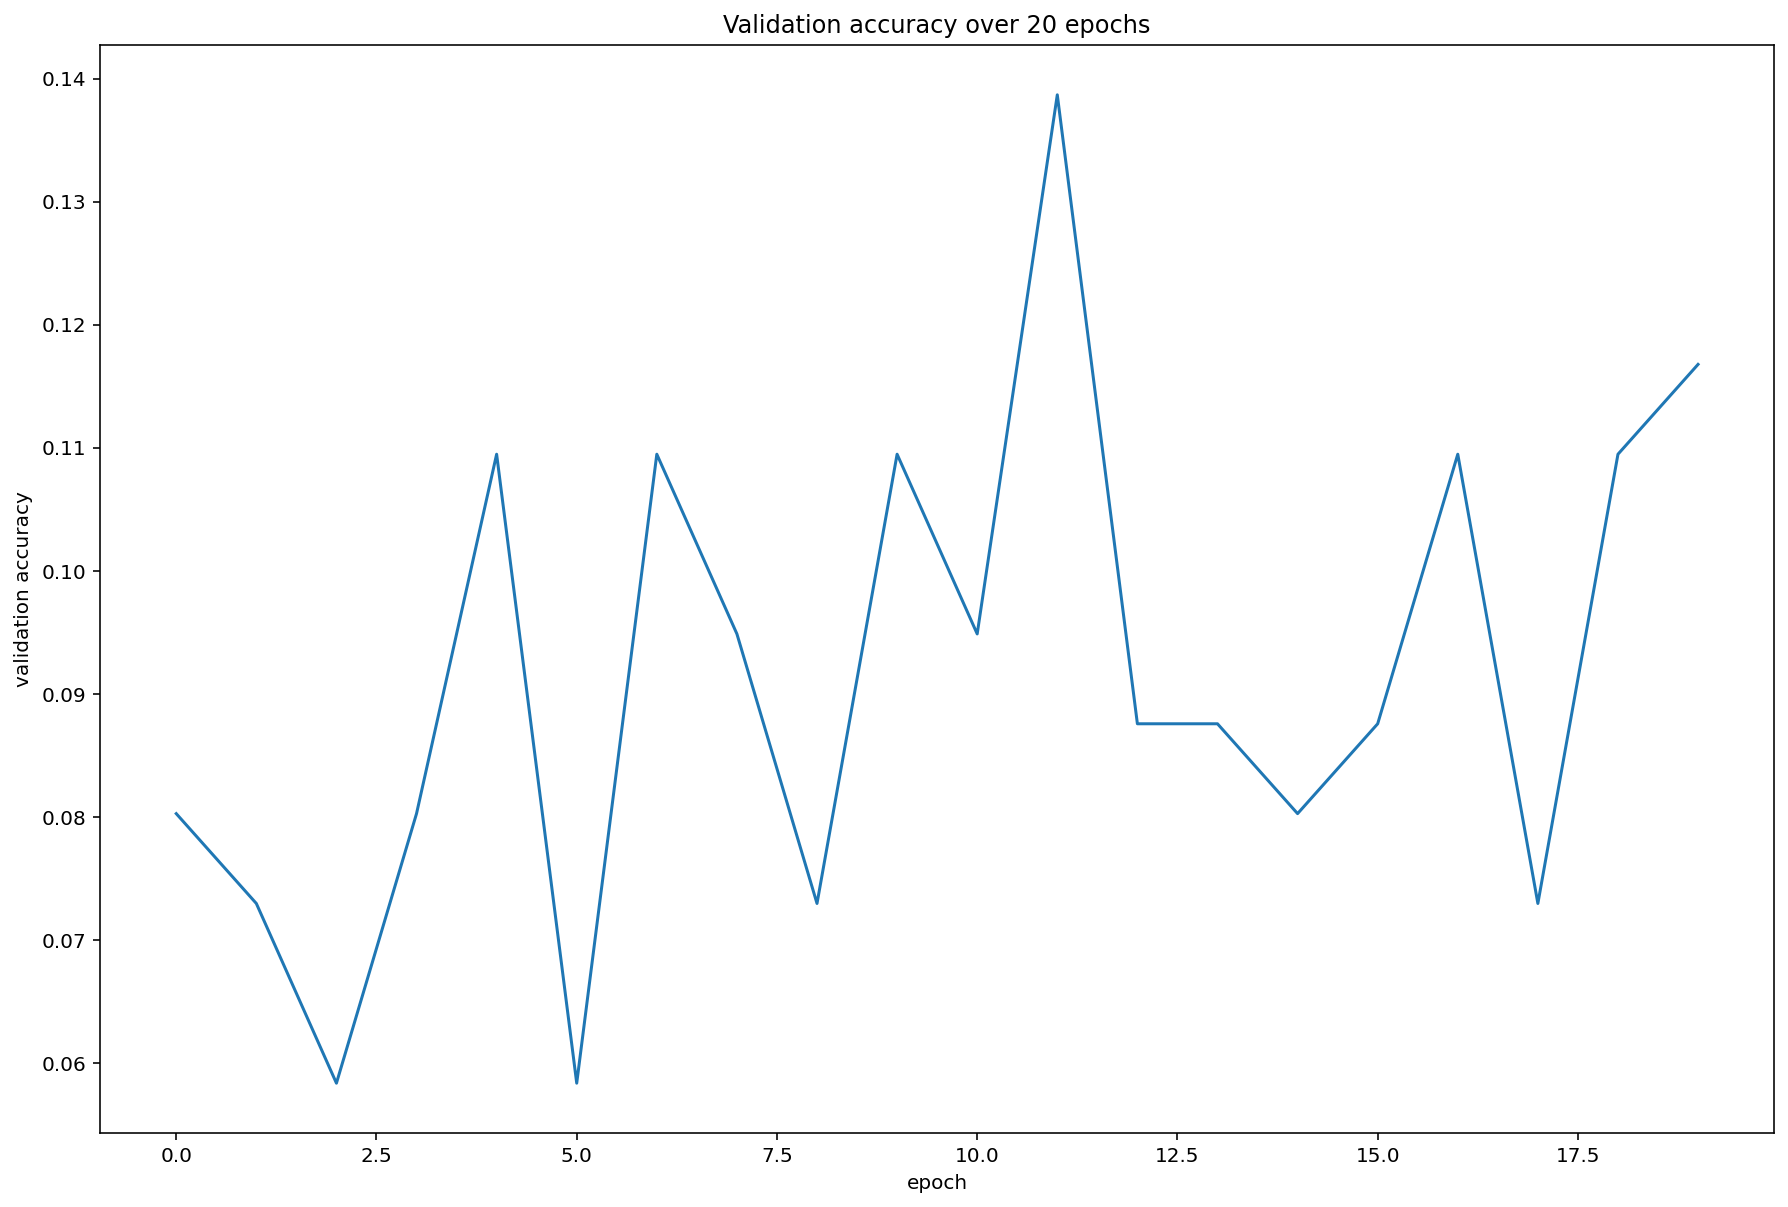

In [40]:
plt.figure(figsize=(15, 10))
plt.plot(list(hist_2.history.values())[3])
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('Validation accuracy over 20 epochs')
plt.show()

# RNN 2

In [41]:
model = create_network(network_input_train, n_vocab)
filepath = "/content/drive/My Drive/maes/check/4/weights-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
print(model.summary())
hist_3 = model.fit(network_input_train, network_output_train, epochs = 100,
            validation_data = (network_input_val, network_output_val), 
            batch_size = 128, callbacks=callbacks_list)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 100, 512)          263168    
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 100, 512)          524800    
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 100, 512)          524800    
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 512)               524800    
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)              

## Plotting Graphs

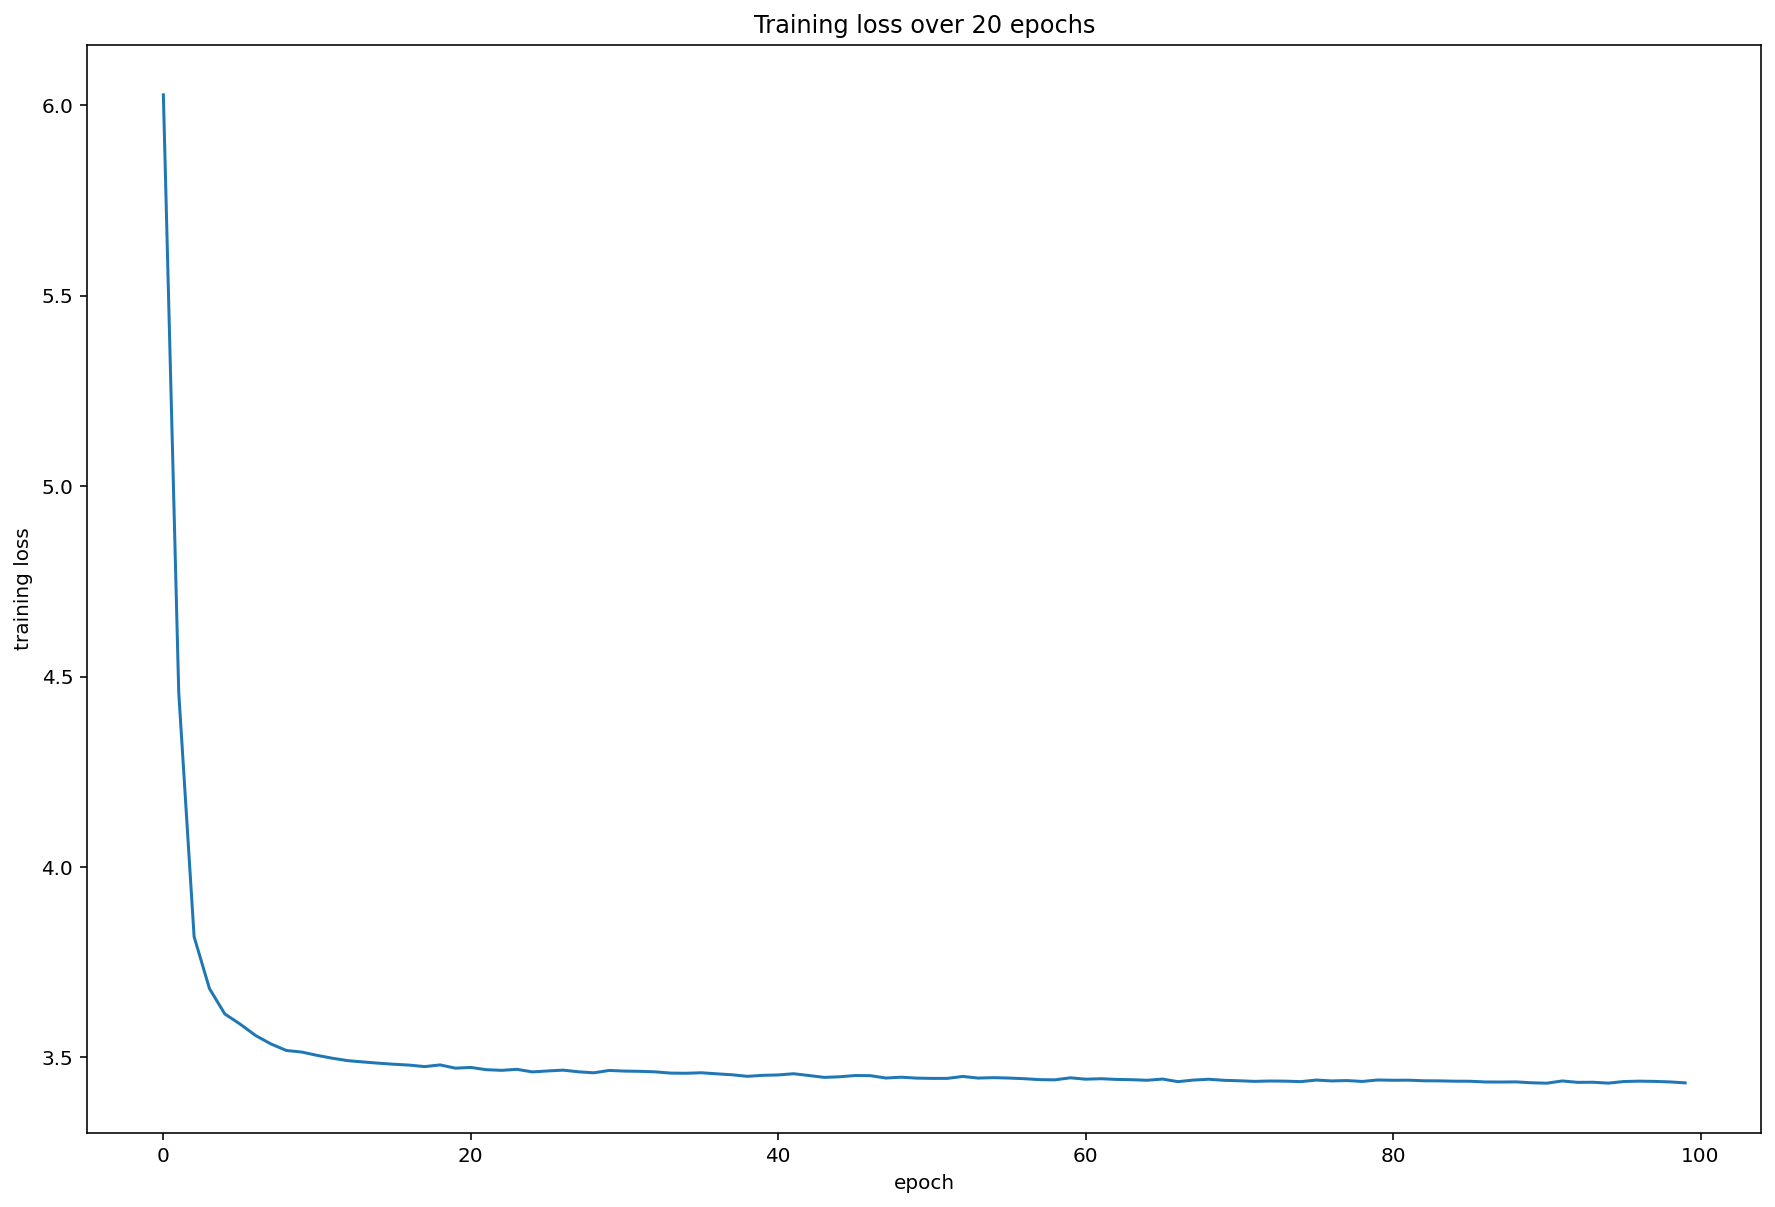

In [42]:
plt.figure(figsize=(15, 10))
plt.plot(list(hist_3.history.values())[0])
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.title('Training loss over 20 epochs')
plt.show()

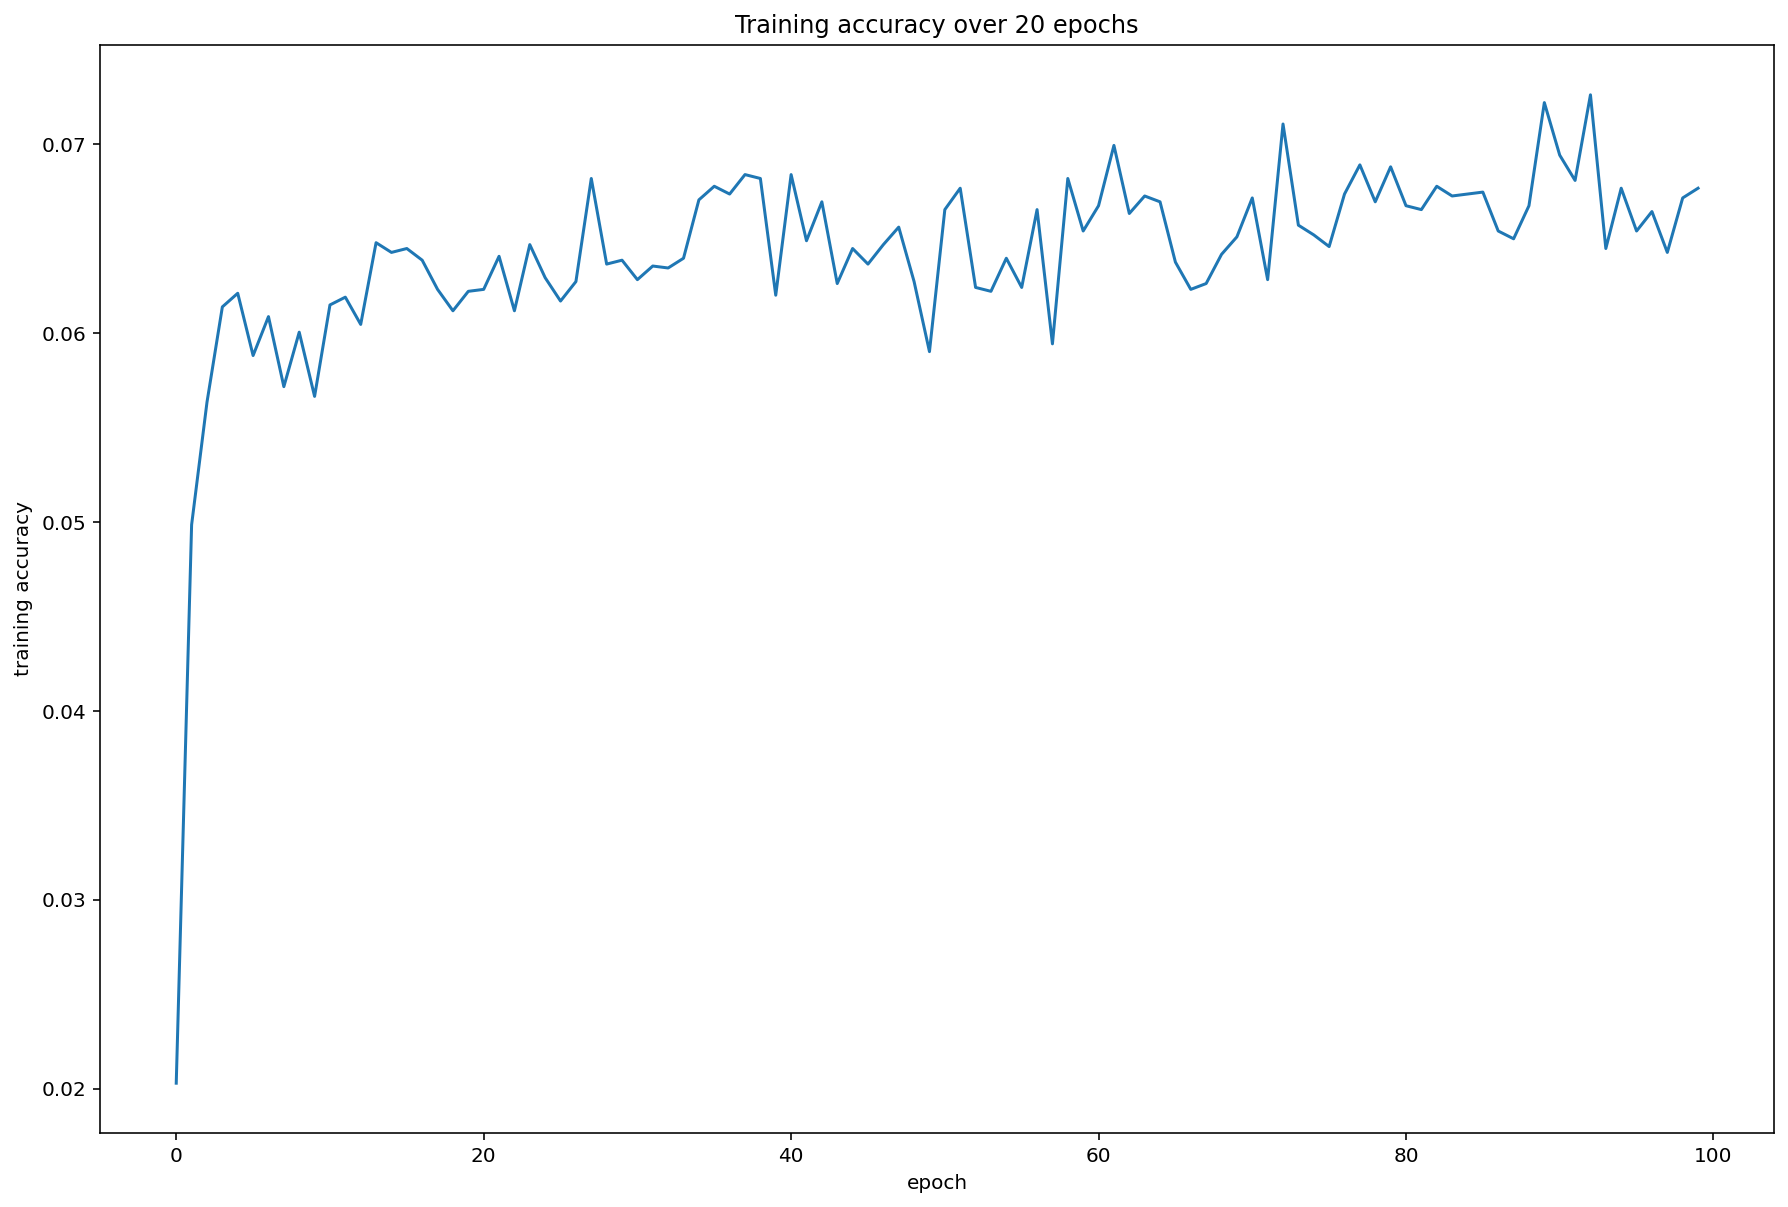

In [43]:
plt.figure(figsize=(15, 10))
plt.plot(list(hist_3.history.values())[1])
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.title('Training accuracy over 20 epochs')
plt.show()

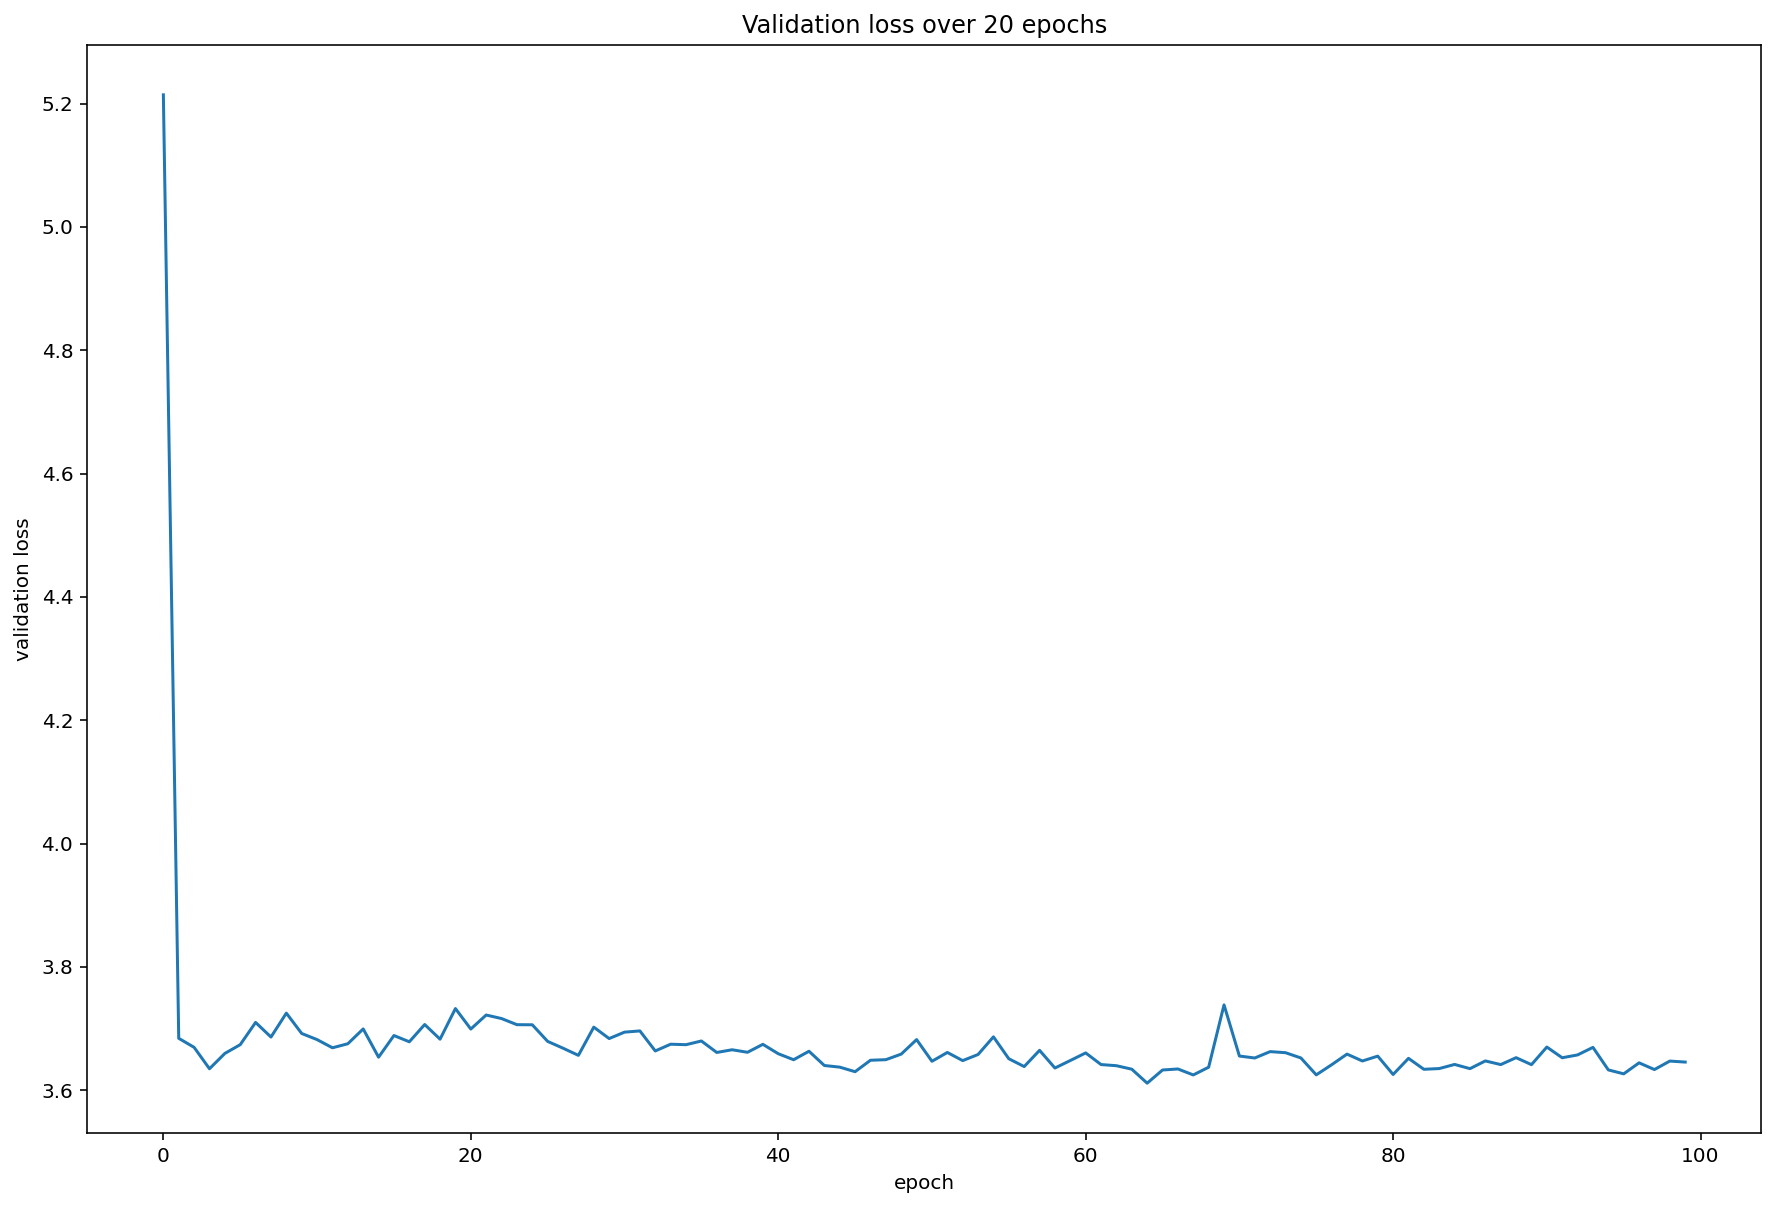

In [44]:
plt.figure(figsize=(15, 10))
plt.plot(list(hist_3.history.values())[2])
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.title('Validation loss over 20 epochs')
plt.show()

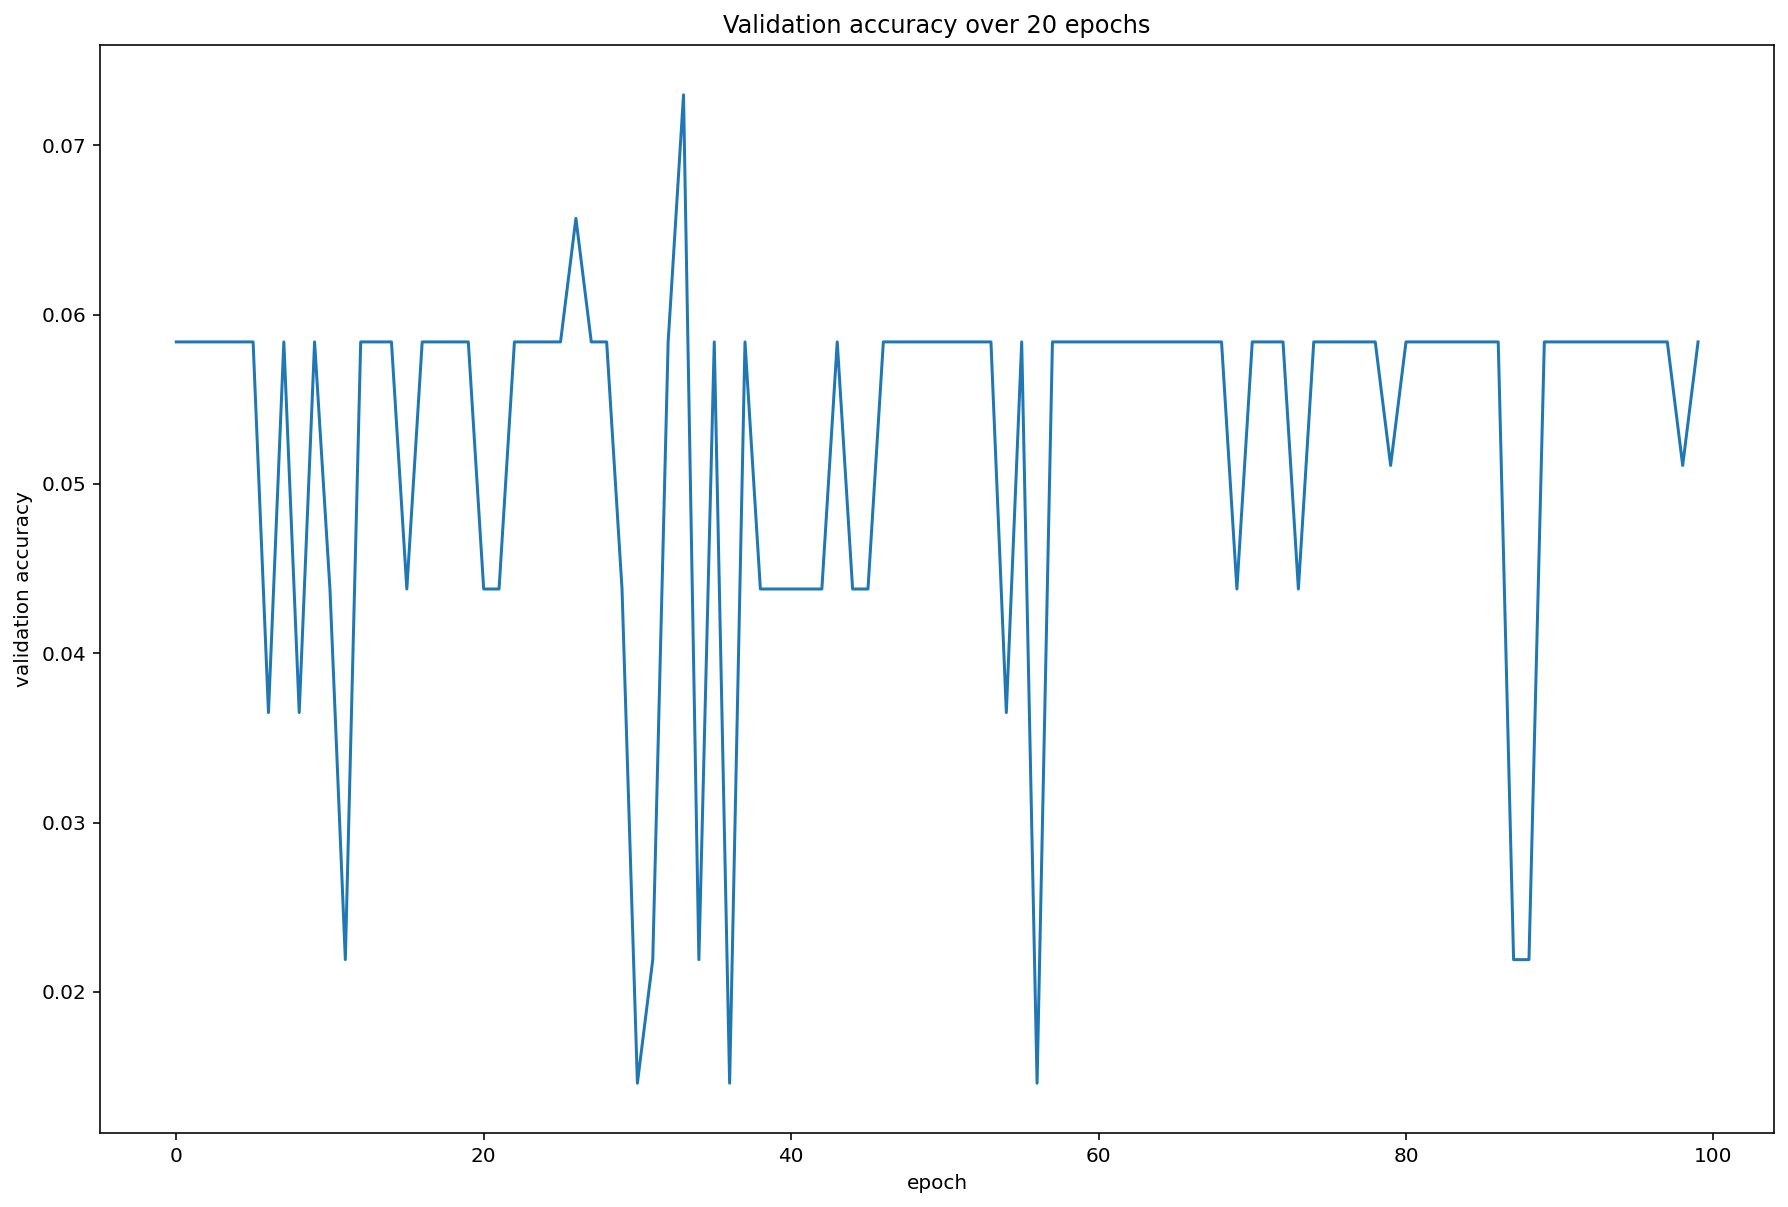

In [45]:
plt.figure(figsize=(15, 10))
plt.plot(list(hist_3.history.values())[3])
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('Validation accuracy over 20 epochs')
plt.show()